In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
pd.set_option('display.max_columns', None) # 展示所有列
plt.rcParams['axes.unicode_minus']=False # 正常显示符号

# 导入Spark依赖包
from pyspark.sql import SparkSession
from pyspark.sql.types import *

# 显著性检验
from scipy.stats import ttest_ind

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [851]:
# 配置资源利用信息
spark = SparkSession \
    .builder \
    .appName("jupyter_example_aqi_lstm") \
    .enableHiveSupport() \
    .config("spark.executor.instances", "10") \
    .config("spark.executor.memory","5g") \
    .config("spark.executor.cores","5") \
    .config("spark.driver.memory","10g") \
    .config("spark.sql.shuffle.partitions","50") \
    .config("hive.exec.dynamici.partition",True) \
    .config("hive.exec.dynamic.partition.mode","nonstrict") \
    .getOrCreate()

In [850]:
spark.stop()

In [337]:
sql=""" 
select * from tmp.tmp_zl_udata_ab_24q1 
""" 
abin=spark.sql(sql).toPandas() 

In [852]:
sql=""" 
select * from dev.dev_shenji_abtest_aa_shunt_result_421103875834122240_det_d 
""" 
ab=spark.sql(sql).toPandas() 

In [338]:
abin['excel_dur_file_aft_avg']=(abin.excel_dur_file_aft_step1+abin.excel_dur_file_aft_step2)/2
abin['excel_dur_file_pre_avg']=(abin.excel_dur_file_pre_step1+abin.excel_dur_file_pre_step2)/2
abin['excel_dur_file_diff']=abin.excel_dur_file_aft_avg-abin.excel_dur_file_pre_avg
abin['excel_dur_file_diff_pp']=abin.excel_dur_file_diff/abin.excel_dur_file_pre_avg
abin['excel_dur_file_diff_tag']=abin['excel_dur_file_diff_pp'].apply(lambda x: np.floor(x*10)/10 if x<=1 else 1)
abin['excel_dur_file_all_aft_avg']=(abin.excel_dur_file_all_aft_step1+abin.excel_dur_file_all_aft_step2)/2
abin['excel_dur_file_all_pre_avg']=(abin.excel_dur_file_all_pre_step1+abin.excel_dur_file_all_pre_step2)/2
abin['excel_dur_file_all_diff']=abin.excel_dur_file_all_aft_avg-abin.excel_dur_file_all_pre_avg
abin['excel_dur_file_all_diff_pp']=abin.excel_dur_file_all_diff/abin.excel_dur_file_all_pre_avg
abin['excel_dur_file_all_diff_tag']=abin['excel_dur_file_all_diff_pp'].apply(lambda x:np.floor(x*10)/10  if x<=1 else 1)

abin['ud_dt_tag']=abin['ud_dt'].apply(lambda x: np.floor(x/10)*10)

abin['dtp_pre_tag']=abin['dtp_pre'].apply(lambda x: np.floor(x*10)/10 if x<=1 else 1)
abin['dtp_aft_tag']=abin['dtp_aft'].apply(lambda x: np.floor(x*10)/10 if x<=1 else 1)
abin['dtp_diff']=abin.dtp_aft-abin.dtp_pre
abin['dtp_diff_tag']=abin['dtp_diff'].apply(lambda x: np.floor(x*10)/10 if x<=1 else 1)

abin['file_pre_tag']=abin['file_pre'].apply(lambda x: np.floor(x/5)*5)
abin['file_aft_tag']=abin['file_aft'].apply(lambda x: np.floor(x/5)*5)
abin['file_diff']=abin.file_aft-abin.file_pre
abin['file_diff_tag']=abin['file_diff'].apply(lambda x: np.floor(x/5)*5)

In [339]:
import sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
abin[['excel_dur_file_all_pre_avg_sd','excel_dur_file_all_aft_avg_sd','file_pre_sd','file_aft_sd','dtp_pre_sd','dtp_aft_sd']]=scaler.fit_transform(abin[['excel_dur_file_all_pre_avg','excel_dur_file_all_aft_avg','file_pre','file_aft','dtp_pre','dtp_aft']])

In [ ]:
abin

In [646]:
abin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132467 entries, 0 to 132466
Data columns (total 76 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   label                          132467 non-null  object 
 1   user_erp                       132467 non-null  object 
 2   if_fg                          132467 non-null  object 
 3   first_visit_date               132467 non-null  object 
 4   if_lz                          132467 non-null  object 
 5   level_grade                    132467 non-null  object 
 6   work_post_name                 132467 non-null  object 
 7   dept_full_name                 132463 non-null  object 
 8   line                           132467 non-null  object 
 9   org_busi_group_1               132462 non-null  object 
 10  org_busi_group_2               132399 non-null  object 
 11  org_busi_group_3               130909 non-null  object 
 12  zjxl                          

# 实验组筛选

In [341]:
af1=abin[(abin.label=='A')&(abin.if_lz=='1')&(abin.excel_dur_file_all_pre>0)&(~abin.line.isin(['非物流','国际物流事业部','市场与公共事务部','技术与数据智能部']))]         
bf1=abin[(abin.label=='B')&(abin.if_fg=='0')&(abin.if_lz=='1')&(abin.excel_dur_file_all_pre>0)&(~abin.line.isin(['非物流','国际物流事业部','市场与公共事务部','技术与数据智能部']))]         

In [357]:
ball

label       user_erp if_fg first_visit_date if_lz level_grade  \
0         B        baijia3     0       2999-01-01     1          O2   
1         B     baijunjie3     0       2999-01-01     1          P3   
2         B    baixuefeng3     0       2999-01-01     1         ST4   
3         B   baochaoneng1     0       2999-01-01     1          O2   
4         B    baozhongde1     0       2999-01-01     1          O2   
...     ...            ...   ...              ...   ...         ...   
10141     B   zoujianfeng1     0       2999-01-01     1          O2   
10142     B    zoukaipeng1     0       2999-01-01     1          O2   
10143     B       zoutong7     0       2999-01-01     1          P6   
10144     B  zuomingguang1     0       2999-01-01     1          O4   
10145     B   zuomingxing1     0       2999-01-01     1          O2   

      work_post_name                                  dept_full_name    line  \
0               盘点员岗       京东集团-京东物流-供应链事业部-广东省区-广东深惠市-深圳商超B个护清洁仓1号库   供应链其他   
1             供应链销售岗                京东集团-京东物流-供应链事业部-北京区-销售部-医药行业销售组   供应链其他   
2             维修工程师岗        京东集团-京东物流-供应链事业部-北京区-北京服务中心-北京维修组-维修业务一组     服务+   
3               仓管员岗            京东集团-京东物流-快递快运事业部-广西省区-广西东片区-贵港浔州营业部    快快终端   
4              入库组长岗  京东集团-京东物流-供应链事业部-四川省区-四川青白江区-成都米面粮油车旅美妆综合仓-入库组   供应链其他   
...              ...                                             ...     ...   
10141           盘点员岗    京东集团-京东物流-供应链事业部-广东省区-广东广州市-广州亚一综合A仓1号库-在库1组   供应链其他   
10142        营业部负责人岗          京东集团-京东物流-快递快运事业部-湖南省区-长沙东片区-长沙汽车东站营业部    快快终端   
10143          系统实施岗                    京东集团-京东物流-行业大客户部-解决方案部-系统实施组  行业大客户部   
10144         系统协调员岗       京东集团-京东物流-供应链事业部-江苏省区-江苏服务中心-江苏维修组-维修业务一组     服务+   
10145          运输专员岗              京东集团-京东物流-供应链事业部-浙江省区-浙江运输中心-杭州运输组   供应链其他   

      org_busi_group_1 org_busi_group_2 org_busi_group_3 zjxl  \
0               供应链事业部             广东省区            广东深惠市    O   
1               供应链事业部              北京区              销售部    P   
2               供应链事业部              北京区           北京服务中心   ST   
3              快递快运事业部             广西省区            广西东片区    O   
4               供应链事业部             四川省区           四川青白江区    O   
...                ...              ...              ...  ...   
10141           供应链事业部             广东省区            广东广州市    O   
10142          快递快运事业部             湖南省区            长沙东片区    O   
10143           行业大客户部            解决方案部            系统实施组    P   
10144           供应链事业部             江苏省区           江苏服务中心    O   
10145           供应链事业部             浙江省区           浙江运输中心    O   

      main_sequnce_descr sequence_descr subsequence_descr first_line  \
0                   操作序列         技能作业序列            技能作业序列        供应链   
1                   专业序列           销售序列              销售序列        供应链   
2                   操作序列         技术作业序列            技术作业序列        供应链   
3                   操作序列         技能作业序列            技能作业序列       快递快运   
4                   操作序列         技能作业序列            技能作业序列        供应链   
...                  ...            ...               ...        ...   
10141               操作序列         技能作业序列            技能作业序列        供应链   
10142               操作序列         快递作业序列            快递作业序列       快递快运   
10143               专业序列       物流产品服务序列          技术产品服务序列         销售   
10144               操作序列         综合作业序列            综合作业序列        供应链   
10145               操作序列         综合作业序列            综合作业序列        供应链   

      second_line excel_num  ud_dt  ud_num  ud_num_visit  excel_dur_file_aft  \
0             常温C         0      0     0.0             0            0.666493   
1              职能         0      0     0.0             0            0.415141   
2            服务业务         0      0     0.0             0            0.057130   
3             营业部         0      0     0.0             0            0.361806   
4             常温C         0      0     0.0             0            0.234867   
...           ...       ...    ...     ...           ...          

### 自然趋势

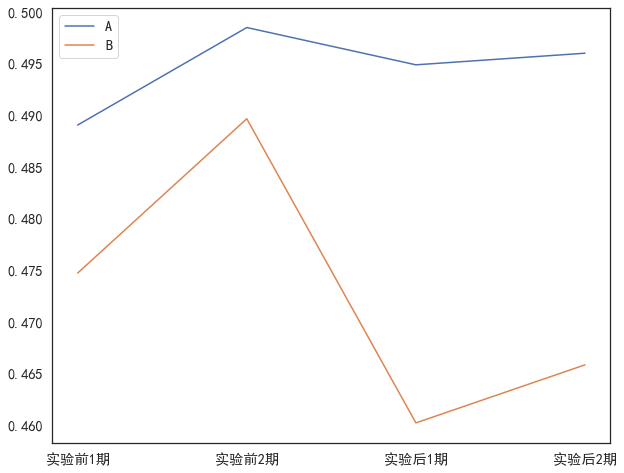

In [845]:
x=['实验前1期','实验前2期','实验后1期','实验后2期']
y1=af1[['excel_dur_file_pre_step1','excel_dur_file_pre_step2','excel_dur_file_aft_step1','excel_dur_file_aft_step2']].mean().tolist()
y2=bf1[['excel_dur_file_pre_step1','excel_dur_file_pre_step2','excel_dur_file_aft_step1','excel_dur_file_aft_step2']].mean().tolist()
plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

不加任何过滤筛选，对照组的下降趋势比实验组明显

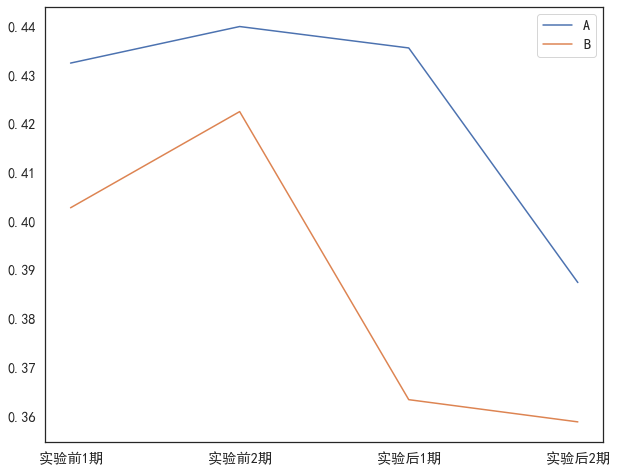

In [552]:
x=['实验前1期','实验前2期','实验后1期','实验后2期']
y1=af1[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf1[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

## 实验组提效分布

In [346]:
# 实验组提效与未提效的比例分布
pd.pivot_table(data=af1,values='user_erp',index='excel_dur_file_diff_tag',aggfunc=pd.Series.nunique,margins=True)

user_erp
excel_dur_file_diff_tag          
-1.0                          238
-0.9                           79
-0.8                          116
-0.7                          232
-0.6                          365
-0.5                          615
-0.4                          783
-0.3                          866
-0.2                          933
-0.1                          859
0.0                           741
0.1                           617
0.2                           539
0.3                           415
0.4                           321
0.5                           286
0.6                           218
0.7                           180
0.8                           154
0.9                           133
1.0                          1283
All                          9973

In [22]:
pd.pivot_table(data=af1,values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=True)

user_erp
excel_dur_file_all_diff_tag          
-1.0                              362
-0.9                              165
-0.8                              228
-0.7                              364
-0.6                              543
-0.5                              696
-0.4                              827
-0.3                              889
-0.2                              813
-0.1                              738
0.0                               662
0.1                               516
0.2                               418
0.3                               344
0.4                               261
0.5                               196
0.6                               193
0.7                               181
0.8                               131
0.9                               131
1.0                              1315
All                              9973

In [365]:
pd.pivot_table(data=af1[af1.excel_num>'0'],values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=True)

user_erp
excel_dur_file_all_diff_tag          
-1.0                                9
-0.9                                6
-0.8                               13
-0.7                               11
-0.6                               15
-0.5                               11
-0.4                               33
-0.3                               32
-0.2                               33
-0.1                               42
0.0                                38
0.1                                26
0.2                                28
0.3                                12
0.4                                12
0.5                                12
0.6                                11
0.7                                 7
0.8                                 9
0.9                                 7
1.0                                72
All                               439

### 提效分布

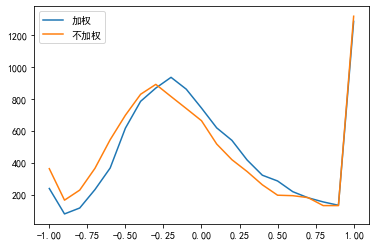

In [49]:
pt1=pd.pivot_table(data=af1,values='user_erp',index='excel_dur_file_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt2=pd.pivot_table(data=af1,values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt1.excel_dur_file_diff_tag.astype(float),pt1.user_erp,label='加权')
plt.plot(pt2.excel_dur_file_all_diff_tag.astype(float),pt2.user_erp,label='不加权')
plt.legend()
plt.show()

提效分布大致符合正态分布，加权用数时长的提效分布均值约20%，不加权均值约30%。

In [347]:
pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<=1],values='user_erp',index='ud_dt_tag',aggfunc=pd.Series.nunique,margins=True)

user_erp
ud_dt_tag          
0.0            6127
10.0           1194
20.0            732
30.0            297
40.0            170
50.0             81
60.0             42
70.0             15
All            8658

In [366]:
# 提效特别差的人
pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>1],values='user_erp',index='ud_dt_tag',aggfunc=pd.Series.nunique,margins=True)

user_erp
ud_dt_tag          
0.0             912
10.0            203
20.0            134
30.0             40
40.0             18
50.0              6
60.0              1
80.0              1
All            1315

### UD使用频率和提效的关系

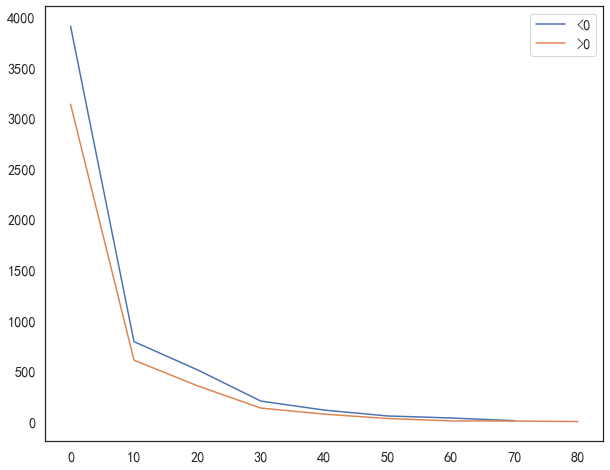

In [596]:
pt11=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<=0],values='user_erp',index='ud_dt_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt22=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>0],values='user_erp',index='ud_dt_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt11.ud_dt_tag.astype(float),pt11.user_erp,label='<0')
plt.plot(pt22.ud_dt_tag.astype(float),pt22.user_erp,label='>0')
plt.legend()
plt.show()

In [367]:
af1.ud_dt_tag.corr(af1.excel_dur_file_all_diff_tag)

-0.02032505963884588

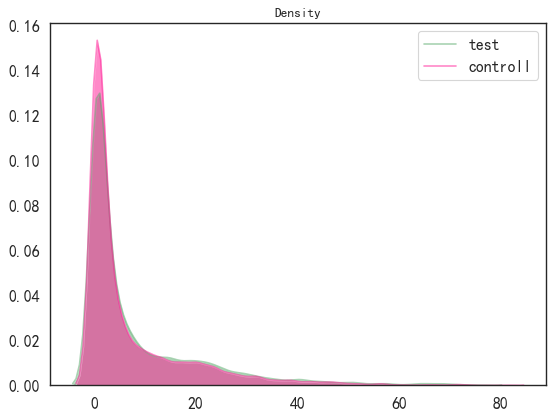

In [598]:
plot_density(af1[af1.excel_dur_file_all_diff_pp<0].ud_dt_visit,af1[af1.excel_dur_file_all_diff_pp>=0].ud_dt_visit)

从UD的使用频率看，大部分覆盖用户的使用频率都较低，且整体上看UD使用频率和提效比例几乎不相关

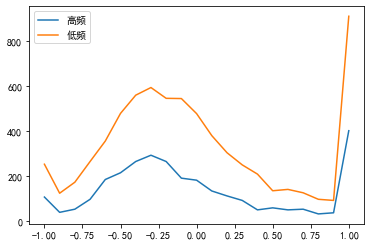

In [368]:
# 线上建表用户
pt1=pd.pivot_table(data=af1[af1.ud_dt_tag>0],values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt2=pd.pivot_table(data=af1[af1.ud_dt_tag==0],values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt1.excel_dur_file_all_diff_tag.astype(float),pt1.user_erp,label='高频')
plt.plot(pt2.excel_dur_file_all_diff_tag.astype(float),pt2.user_erp,label='低频')
plt.legend()
plt.show()

In [352]:
pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>1],values='user_erp',index='dtp_diff_tag',aggfunc=pd.Series.nunique,margins=False)

user_erp
dtp_diff_tag          
-0.4                 1
-0.3                 4
-0.2                55
-0.1               188
 0.0               329
 0.1               257
 0.2               207
 0.3               141
 0.4                73
 0.5                51
 0.6                 9

### 做数频率和提效的关系

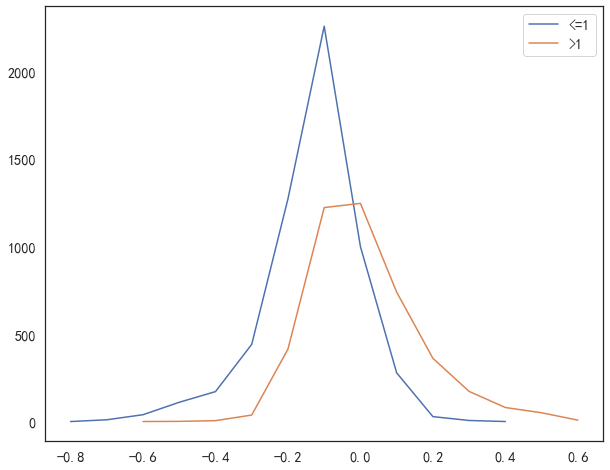

In [602]:
pt111=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<0],values='user_erp',index='dtp_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt222=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>0],values='user_erp',index='dtp_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt111.dtp_diff_tag.astype(float),pt111.user_erp,label='<=1')
plt.plot(pt222.dtp_diff_tag.astype(float),pt222.user_erp,label='>1')
plt.legend()
plt.show()

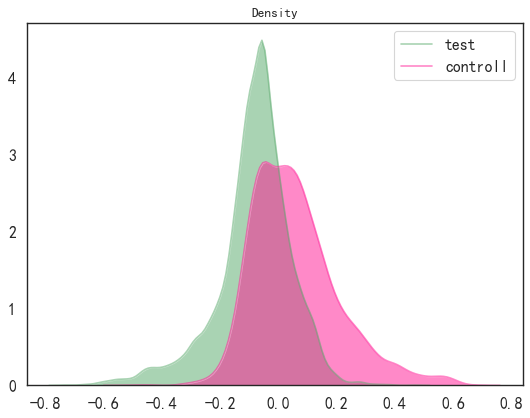

In [604]:
plot_density(af1[af1.excel_dur_file_all_diff_pp<0].dtp_diff,af1[af1.excel_dur_file_all_diff_pp>=0].dtp_diff)

In [88]:
af1.dtp_diff_tag.corr(af1.excel_dur_file_all_diff_tag)

0.3157390608140954

前后做数频率差异与提效具有较强的正相关性，说明未提效的用户可能是需求发生了变化。大部分用户做数频率差异在-10%～60%之间

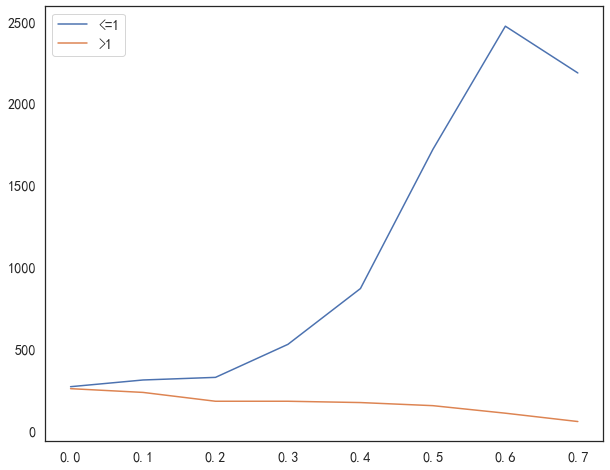

In [560]:
pt111=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<=1],values='user_erp',index='dtp_pre_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt222=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>1],values='user_erp',index='dtp_pre_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt111.dtp_pre_tag.astype(float),pt111.user_erp,label='<=1')
plt.plot(pt222.dtp_pre_tag.astype(float),pt222.user_erp,label='>1')
plt.legend()
plt.show()

In [104]:
af1.dtp_pre_tag.corr(af1.excel_dur_file_all_diff_tag)

-0.11123018818782834

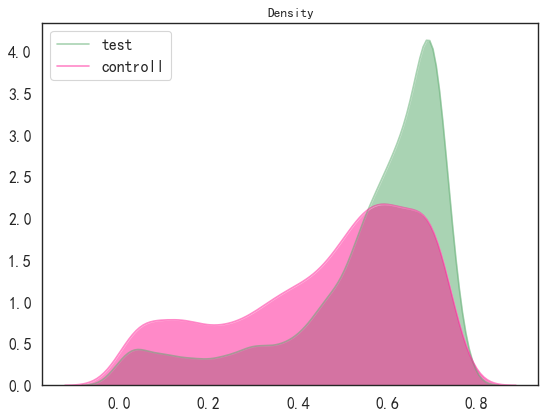

In [605]:
plot_density(af1[af1.excel_dur_file_all_diff_pp<0].dtp_pre,af1[af1.excel_dur_file_all_diff_pp>=0].dtp_pre)

提效较差的用户实验前无做数行为或做数行为很少，不具有可比性，可剔除该部分用户。

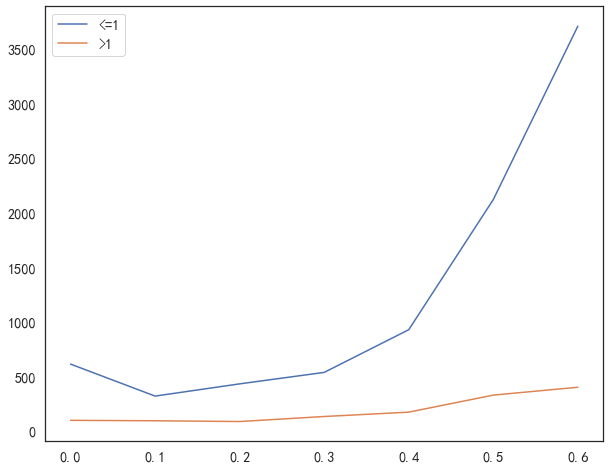

In [606]:
pt111=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<=1],values='user_erp',index='dtp_aft_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt222=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>1],values='user_erp',index='dtp_aft_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt111.dtp_aft_tag.astype(float),pt111.user_erp,label='<=1')
plt.plot(pt222.dtp_aft_tag.astype(float),pt222.user_erp,label='>1')
plt.legend()
plt.show()

### 文件量和提效的关系

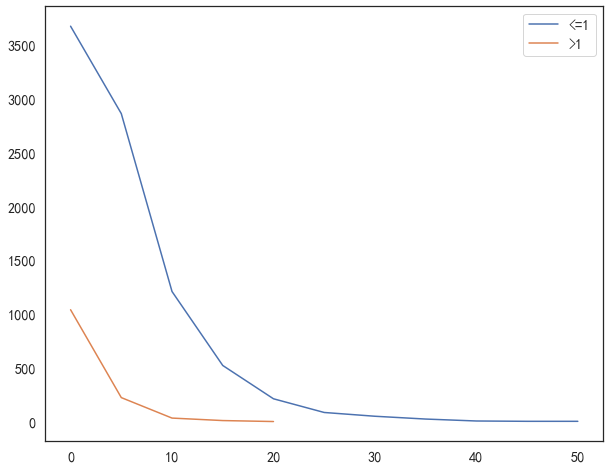

In [607]:
pt111=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<=1],values='user_erp',index='file_pre_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt222=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>1],values='user_erp',index='file_pre_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt111.file_pre_tag.astype(float),pt111.user_erp,label='<=1')
plt.plot(pt222.file_pre_tag.astype(float),pt222.user_erp,label='>1')
plt.legend()
plt.show()

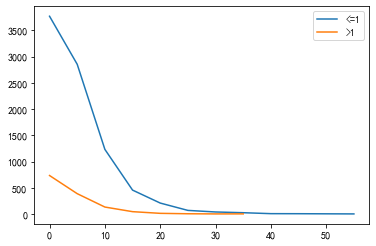

In [152]:
pt111=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<=1],values='user_erp',index='file_aft_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt222=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>1],values='user_erp',index='file_aft_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt111.file_aft_tag.astype(float),pt111.user_erp,label='<=1')
plt.plot(pt222.file_aft_tag.astype(float),pt222.user_erp,label='>1')
plt.legend()
plt.show()

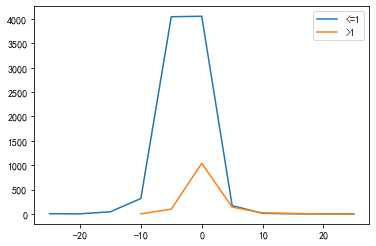

In [154]:
pt111=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<=1],values='user_erp',index='file_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt222=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>1],values='user_erp',index='file_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt111.file_diff_tag.astype(float),pt111.user_erp,label='<=1')
plt.plot(pt222.file_diff_tag.astype(float),pt222.user_erp,label='>1')
plt.legend()
plt.show()

文件量前后差异较小，不可作为剔除依据。

### 用户类型和提效的关系

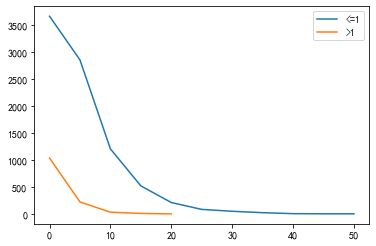

In [354]:
pt111=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp<=1],values='user_erp',index='file_pre_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt222=pd.pivot_table(data=af1[af1.excel_dur_file_all_diff_pp>1],values='user_erp',index='file_pre_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt111.file_pre_tag.astype(float),pt111.user_erp,label='<=1')
plt.plot(pt222.file_pre_tag.astype(float),pt222.user_erp,label='>1')
plt.legend()
plt.show()

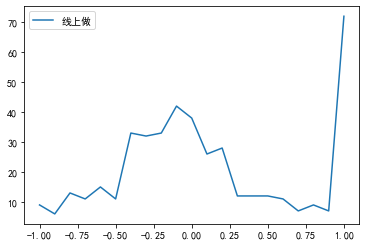

In [155]:
# 线上建表用户
pt1=pd.pivot_table(data=af1[af1.excel_num>'0'],values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt2=pd.pivot_table(data=af1[af1.excel_num=='0'],values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt1.excel_dur_file_all_diff_tag.astype(float),pt1.user_erp,label='线上做')
# plt.plot(pt2.excel_dur_file_all_diff_tag.astype(float),pt2.user_erp,label='线上不做')
plt.legend()
plt.show()


线上建表用户的提效分布均值约在0%～25%，且同样有较多未提效的长尾用户，根据建表行为暂时无法区分提效用户。

In [112]:
# 提效特别差的人
af1[af1.dtp_diff_tag>=0.5]

label       user_erp first_visit_date if_lz level_grade work_post_name  \
12        A       anjixing       2024-01-13     1          M2    营业部负责人岗(业务)   
42        A      baiyanan8       2024-01-23     1          O2         工单处理员岗   
61        A   bfliuxingkun       2024-02-19     1         ST4          质检组长岗   
74        A      bilongjun       2024-01-28     1          O2          运作主管岗   
75        A        binziyi       2024-01-18     1          O2          运作主管岗   
...     ...            ...              ...   ...         ...            ...   
23474     A    zhongjian60       2024-01-11     1          M1    集配站负责人岗(业务)   
23496     A     zhouqilin5       2024-01-22     1          O2           调度员岗   
23550     A  zouguanxiong1       2024-03-31     1          O2           仓管员岗   
23553     A     zouniahui1       2024-01-29     1          O2           仓管员岗   
23554     A     zouruonan1       2024-01-22     1          M1    集配站负责人岗(业务)   

                                  dept_full_name   line org_busi_group_1  \
12          京东集团-京东物流-快递快运事业部-广东省区-深圳东片区-深圳坪山营业部   快快终端          快递快运事业部   
42         京东集团-京东物流-快递快运事业部-黑龙江省区-终端运营部-快递作业流程组   快快终端          快递快运事业部   
61     京东集团-京东物流-供应链事业部-北京区-北京逆向中心-北京逆向仓-高值逆向入库组  供应链其他           供应链事业部   
74           京东集团-京东物流-快递快运事业部-山东省区-威海片区-威海文登营业部   快快终端          快递快运事业部   
75          京东集团-京东物流-快递快运事业部-广东省区-广州中片区-广州芳村营业部   快快终端          快递快运事业部   
...                                          ...    ...              ...   
23474        京东集团-京东物流-快递快运事业部-广东省区-快运片区-广州石井集配站   快快终端          快递快运事业部   
23496   京东集团-京东物流-运力平台部-浙闽运力运营部-浙江公路长途运力组-浙江干线车队  运力平台部            运力平台部   
23550      京东集团-京东物流-快递快运事业部-湖北省区-武昌片区-武汉崇文中心营业部   快快终端          快递快运事业部   
23553        京东集团-京东物流-快递快运事业部-辽宁省区-辽南片区-鞍山锦荣营业部   快快终端          快递快运事业部   
23554      京东集团-京东物流-快递快运事业部-浙江省区-浙江快运片区-湖州德清集配站   快快终端          快递快运事业部   

      org_busi_group_2 org_busi_group_3 zjxl main_sequnce_descr  \
12                广东省区            深圳东片区    M               管理序列   
42               黑龙江省区            终端运营部    O               操作序列   
61                 北京区           北京逆向中心   ST               操作序列   
74                山东省区             威海片区    O               操作序列   
75                广东省区            广州中片区    O               操作序列   
...                ...              ...  ...                ...   
23474             广东省区             快运片区    M               管理序列   
23496          浙闽运力运营部        浙江公路长途运力组    O               操作序列   
23550             湖北省区             武昌片区    O               操作序列   
23553             辽宁省区             辽南片区    O               操作序列   
23554             浙江省区           浙江快运片区    M               管理序列   

      sequence_descr subsequence_descr first_line second_line excel_num  \
12            业务管理序列            业务管理序列       快递快运         营业部         0   
42            综合作业序列            综合作业序列       快递快运         营业部         0   
61            技术作业序列            技术作业序列        供应链          逆向         0   
74            快递作业序列            快递作业序列       快递快运         营业部         0   
75            快递作业序列            快递作业序列       快递快运         营业部         2   
...              ...               ...        ...         ...       ...   
23474         业务管理序列            业务管理序列       快递快运         集配站         0   
23496         综合作业序列            综合作业序列         运力          干线         0   
23550         技能作业序列            技能作业序列       快递快运         营业部         0   
23553         技能作业序列            技能作业序列       快递快运         营业部         0   
23554         业务管理序列            业务管理序列       快递快运         集配站         0   

       ud_dt  ud_num  excel_dur_file_aft  excel_dur_file_all_aft   dtp_aft  \
12        25    38.0            0.824883                0.791441  0.651376   
42        20    23.0            1.586752                1.516748  0.656566   
61         6     6.0            0.556692                0.471047  0.611111   
74         0     NaN            0.220019                0.199392  0.617021   
75        14    22.0            1.68

## 实验组样本过滤后

### 过滤实验前有做数行为的人

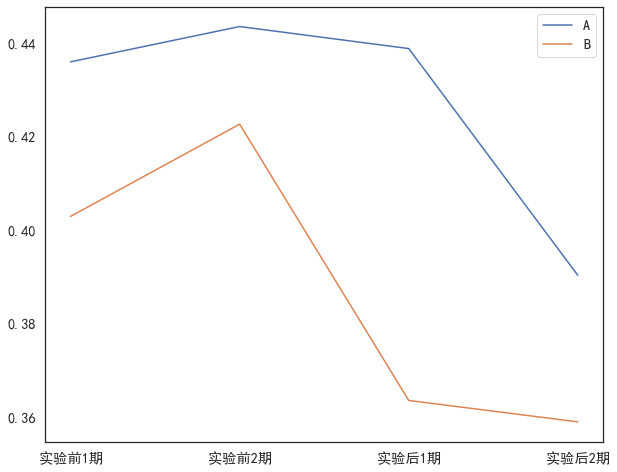

In [621]:
# 实验前做数的人
af2=af1[af1.dtp_pre>0]     
bf2=bf1[bf1.dtp_pre>0]

x=['实验前1期','实验前2期','实验后1期','实验后2期']
# y1=af2[['excel_dur_file_pre_step1','excel_dur_file_pre_step2','excel_dur_file_aft_step1','excel_dur_file_aft_step2']].mean().tolist()
# y2=bf2[['excel_dur_file_pre_step1','excel_dur_file_pre_step2','excel_dur_file_aft_step1','excel_dur_file_aft_step2']].mean().tolist()
y1=af2[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf2[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()


plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

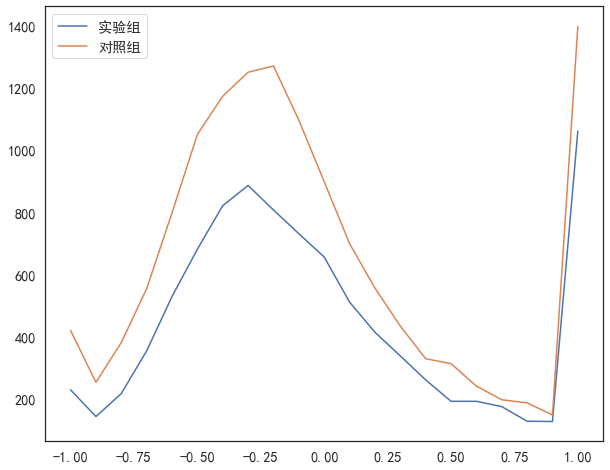

In [564]:
# 过滤后提效分布
pt1=pd.pivot_table(data=af2,values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt2=pd.pivot_table(data=bf2,values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt1.excel_dur_file_all_diff_tag.astype(float),pt1.user_erp,label='实验组')
plt.plot(pt2.excel_dur_file_all_diff_tag.astype(float),pt2.user_erp,label='对照组')
plt.legend()
plt.show()

-0.025223740785972837 -0.05159137701249068


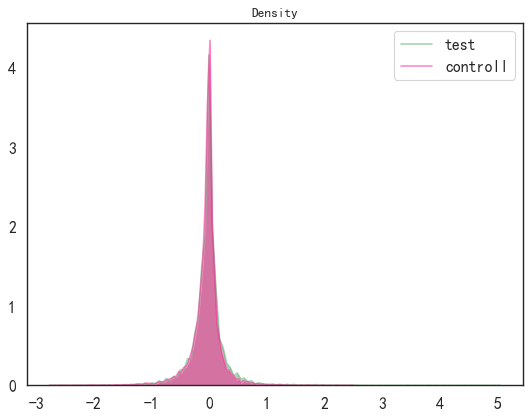

In [591]:
# 实验组和对照组的提效分布基本一致，无显著差异
print(af2.excel_dur_file_all_diff.mean(),bf2.excel_dur_file_all_diff.mean())
plot_density(af2.excel_dur_file_all_diff,bf2.excel_dur_file_all_diff)

### 过滤实验前低频做数的人

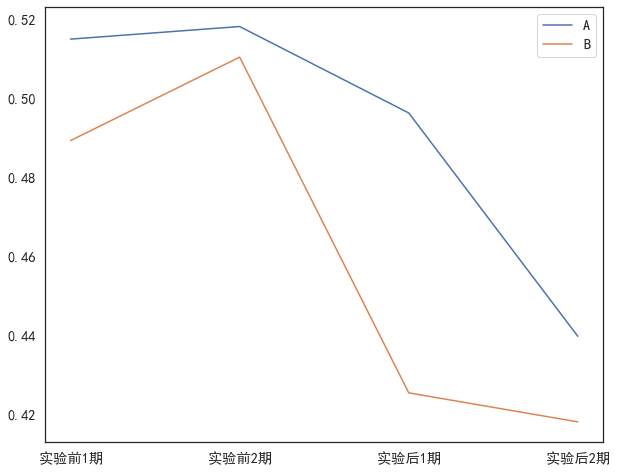

In [612]:
# af2=af1[(af1.dtp_pre_tag>0.3)&(af1.excel_dur_file_all_diff_tag<1)]     
af2=af1[(af1.dtp_pre>0.3)]     
bf2=bf1[bf1.dtp_pre>0.3]

x=['实验前1期','实验前2期','实验后1期','实验后2期']
y1=af2[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf2[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

-0.048542620235471574 -0.07807630950865001


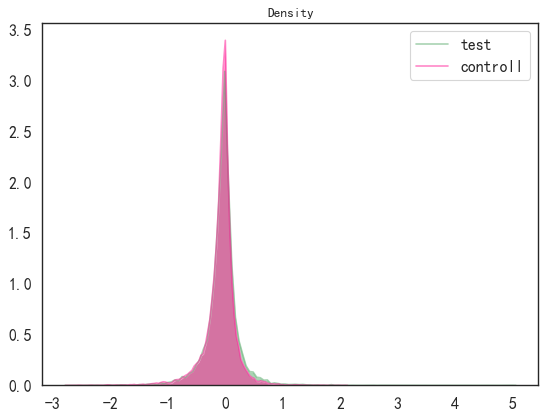

In [613]:
print(af2.excel_dur_file_all_diff.mean(),bf2.excel_dur_file_all_diff.mean())
plot_density(af2.excel_dur_file_all_diff,bf2.excel_dur_file_all_diff)

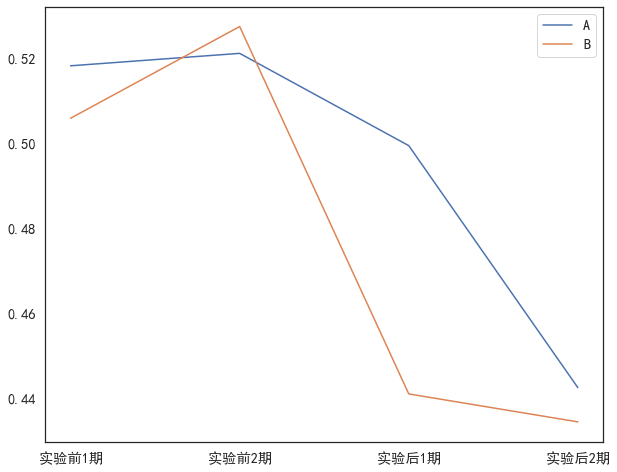

In [614]:
x=['实验前1期','实验前2期','实验后1期','实验后2期']
y1=af2[af2.work_post_name!='销售岗'][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf2[bf2.work_post_name!='销售岗'][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

去除销售等明显不做数的岗位后时长均有上升，对对照组影响更大。

### 过滤未线上化报表的看数人员

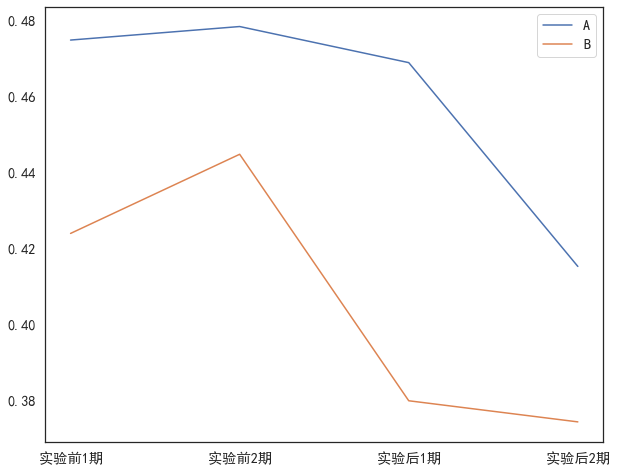

In [623]:
# 过滤只通过京me看数的用户
# af3=af2[af2.ud_num_visit>0]   
af2=af1[(af1.dtp_pre_tag>0)&(af1.ud_num_visit>0)] 
bf2=bf1[bf1.dtp_pre_tag>0]

x=['实验前1期','实验前2期','实验后1期','实验后2期']
y1=af2[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf2[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

-0.03449467639665688 -0.05716415742773314


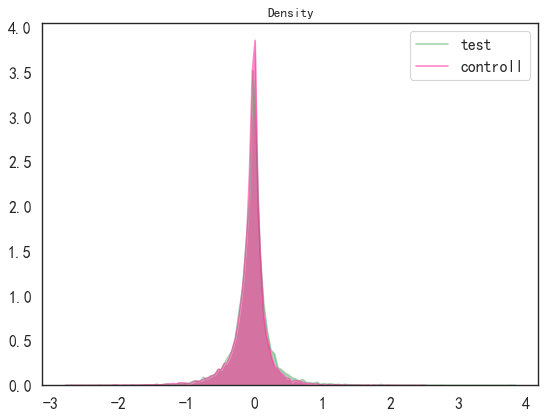

In [624]:
# 实验组和对照组的提效分布基本一致，无显著差异
print(af2.excel_dur_file_all_diff.mean(),bf2.excel_dur_file_all_diff.mean())
plot_density(af2.excel_dur_file_all_diff,bf2.excel_dur_file_all_diff)

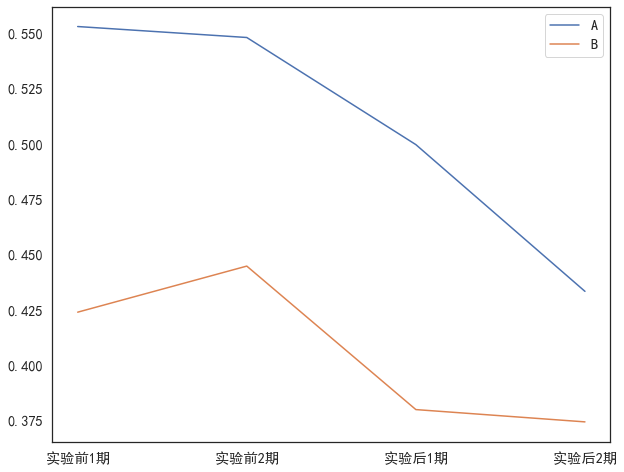

In [619]:
# 过滤低频做数的人
af4=af3[af3.dtp_pre_tag>=0.3]
bf2=bf1[bf1.dtp_pre_tag>0]

x=['实验前1期','实验前2期','实验后1期','实验后2期']
y1=af4[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf2[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

In [644]:
len(af1[(af1.dtp_pre_tag>=0)&(af1.ud_num_visit>0)])

7736

### 过滤时长异常的人

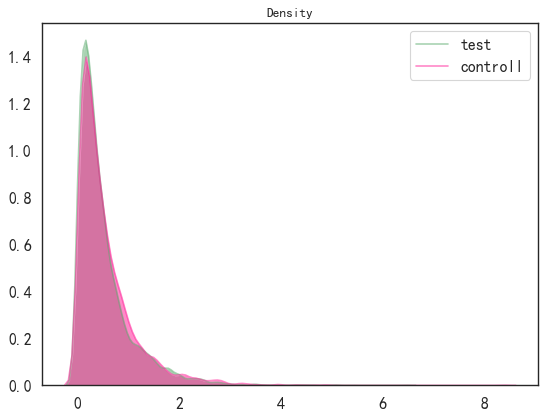

In [807]:
# 现状。
plot_density(af3.excel_dur_file_all_pre_avg,bf3_t4.excel_dur_file_all_pre_avg)

In [806]:
avg=af3.excel_dur_file_all_pre_avg.mean()
std=af3.excel_dur_file_all_pre_avg.std()
print(avg,'\t',std)
print(len(af3[af3.excel_dur_file_all_pre_avg>=0.05]))  # 剔除实验组样本后样本量少了600

0.5153882976865265 	 0.5396256151392381
5994


In [813]:
avg=bf3_t4.excel_dur_file_all_pre_avg.mean()
std=bf3_t4.excel_dur_file_all_pre_avg.std()
print(avg,'\t',std)
print(len(bf3_t4[bf3_t4.excel_dur_file_all_pre_avg<2.5]))
len(bf3_t4)

0.5587467354542609 	 0.5738054632802887
4694


4765

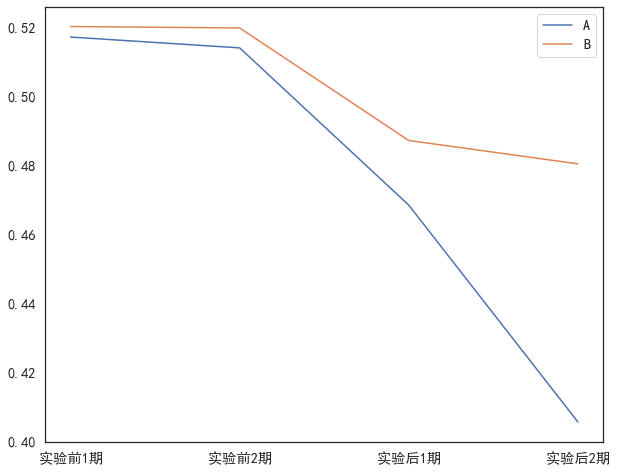

In [811]:
x=['实验前1期','实验前2期','实验后1期','实验后2期']
# y1=af2[af2.excel_dur_file_all_pre_avg>=0.1][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y1=af3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf3_t3[(bf3_t3.step21<=1.5)&(bf3_t3.excel_dur_file_all_pre_avg<2.5)][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

0.5178597198372024 0.5153882976865265


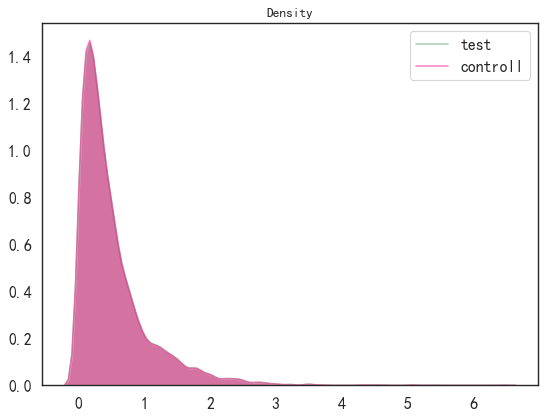

In [844]:
at=af3[af3.work_post_name!='销售岗']
bt=af3
print(at.excel_dur_file_all_pre_avg.mean(),bt.excel_dur_file_all_pre_avg.mean())
plot_density(at.excel_dur_file_all_pre_avg,bt.excel_dur_file_all_pre_avg)

### 最终过滤结果

In [819]:
af2=af1[(af1.dtp_pre>0)&(af1.ud_num_visit>0)&(af1.excel_dur_file_all_diff_tag<1)]
af3=af1[(af1.dtp_pre_tag>0)&(af1.ud_num_visit>0)&(af1.excel_dur_file_all_diff_tag<1)]
af4=af1[(af1.dtp_pre_tag>=0.3)&(af1.ud_num_visit>0)&(af1.excel_dur_file_all_diff_tag<1)]
bf2=bf1[bf1.dtp_pre_tag>0]
af5=af3[af3.excel_dur_file_all_pre_avg>=0.05] # 过滤实验前时长异常低的人

# 对照组筛选

对照组实验前2期时长异常高，分析异常原因。发现存在12月上半月有些人未监控到，以及一些正常需求变化导致的step2较step1高。

In [667]:
tmp=bf2.copy()
tmp['tag']=tmp.apply(lambda x:1 if x.excel_dur_file_all_pre_step2>x.excel_dur_file_all_pre_step1*1.3 else 0,axis=1)
tmp['step21']=tmp.apply(lambda x:(x.excel_dur_file_all_pre_step2-x.excel_dur_file_all_pre_step1)/(x.excel_dur_file_all_pre_step1+0.000000001),axis=1)


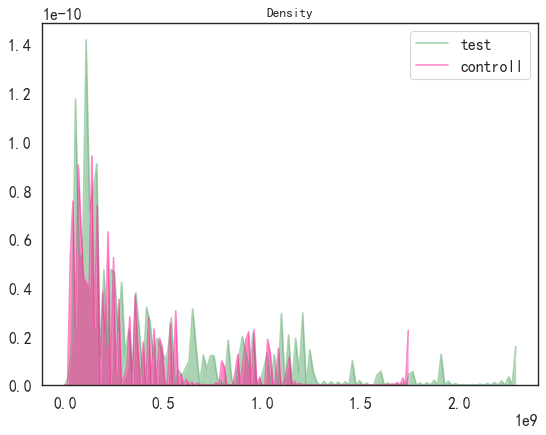

In [670]:
plot_density(tmp[tmp.zjxl=='O'].step21,tmp[tmp.zjxl=='P'].step21)

In [690]:
len(af4)
print(len(abin[(abin.label=='B')&(abin.if_fg=='0')&(abin.if_lz=='1')&(~abin.line.isin(['非物流','国际物流事业部','市场与公共事务部','技术与数据智能部']))]))
print(len(bf1))
print(len(bf2))
print(len(bf3))

23979
14385
13645
12042


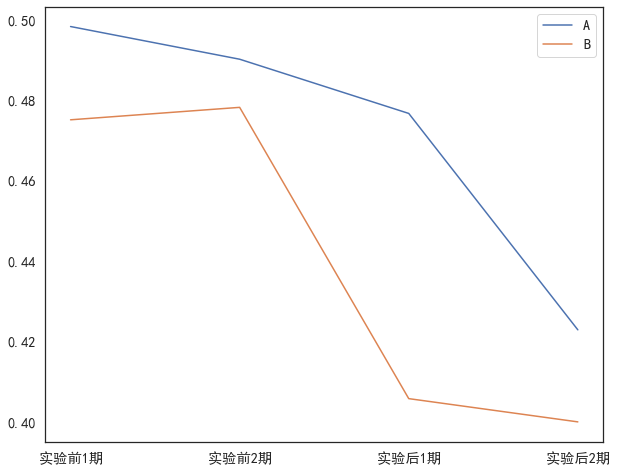

In [685]:
af4=af1[(af1.dtp_pre_tag>0)&(af1.ud_num_visit>0)&(af1.dtp_pre_step1>0.1)]
bf3=bf1[(bf1.dtp_pre_tag>0)&(bf1.excel_dur_file_all_pre_step1>0)&(bf1.dtp_pre_step1>0.2)]

x=['实验前1期','实验前2期','实验后1期','实验后2期']
y1=af4[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

In [673]:
pd.pivot_table(data=tmp,values='user_erp',index=['tag','line','work_post_name'],aggfunc=pd.Series.nunique,margins=False)

user_erp
tag line  work_post_name          
0   供应链其他 KA运维岗                 25
          KA销售岗                 20
          KA项目经理岗               33
          RMA员岗                 68
          RMA组长岗                 7
...                            ...
1   运力平台部 运输组长岗                 12
          项目结算岗                  1
          项目运营岗                  2
          飞机性能岗                  2
          飞行监察岗                  1

[785 rows x 1 columns]

In [370]:
ball=bf2.copy().reset_index(drop=True)

# 包含
ball.head(10)

label      user_erp if_fg first_visit_date if_lz level_grade work_post_name  \
0     B      anzhigao     0       2999-01-01     1         ST4          设备组长岗   
1     B       baijia3     0       2999-01-01     1          O2           盘点员岗   
2     B    baijunjie3     0       2999-01-01     1          P3         供应链销售岗   
3     B  baochaoneng1     0       2999-01-01     1          O2           仓管员岗   
4     B      baoying7     0       2999-01-01     1          P4          能力提升岗   
5     B   baozhongde1     0       2999-01-01     1          O2          入库组长岗   
6     B     bfniutong     0       2999-01-01     1          O4         异常处理员岗   
7     B  bfwangjianan     0       2999-01-01     1          P7          销售策略岗   
8     B         bihui     0       2999-01-01     1          O2          运作主管岗   
9     B    bijiandong     0       2999-01-01     1          P7          销售策略岗   

                                   dept_full_name   line org_busi_group_1  \
0               京东集团-京东物流-供应链事业部-江苏省区-运营改善部-设备服务组  供应链其他           供应链事业部   
1       京东集团-京东物流-供应链事业部-广东省区-广东深惠市-深圳商超B个护清洁仓1号库  供应链其他           供应链事业部   
2                京东集团-京东物流-供应链事业部-北京区-销售部-医药行业销售组  供应链其他           供应链事业部   
3            京东集团-京东物流-快递快运事业部-广西省区-广西东片区-贵港浔州营业部   快快终端          快递快运事业部   
4               京东集团-京东物流-供应链事业部-广东省区-运营改善部-能力提升组  供应链其他           供应链事业部   
5  京东集团-京东物流-供应链事业部-四川省区-四川青白江区-成都米面粮油车旅美妆综合仓-入库组  供应链其他           供应链事业部   
6         京东集团-京东物流-供应链事业部-北京区-北京逆向中心-北京逆向仓-异常处理组  供应链其他           供应链事业部   
7                    京东集团-京东物流-供应链事业部-销售拓展部-云仓拓展组  供应链其他           供应链事业部   
8             京东集团-京东物流-快递快运事业部-江西省区-抚鹰片区-鹰潭月湖营业部   快快终端          快递快运事业部   
9                 京东集团-京东物流-供应链事业部-湖北省区-销售部-销售服务组  供应链其他           供应链事业部   

  org_busi_group_2 org_busi_group_3 zjxl main_sequnce_descr sequence_descr  \
0             江苏省区            运营改善部   ST               操作序列         技术作业序列   
1             广东省区            广东深惠市    O               操作序列         技能作业序列   
2              北京区              销售部    P               专业序列           销售序列   
3             广西省区            广西东片区    O               操作序列         技能作业序列   
4             广东省区            运营改善部    P               专业序列         业务运营序列   
5             四川省区           四川青白江区    O               操作序列         技能作业序列   
6              北京区           北京逆向中心    O               操作序列         技能作业序列   
7            销售拓展部            云仓拓展组    P               专业序列           销售序列   
8             江西省区             抚鹰片区    O               操作序列         快递作业序列   
9             湖北省区              销售部    P               专业序列           销售序列   

  subsequence_descr first_line second_line excel_num  ud_num  ud_num_visit  \
0            技术作业序列        供应链          职能         0       0             0   
1            技能作业序列        供应链         常温C         0       0             0   
2              销售序列        供应链          职能         0       0             0   
3            技能作业序列       快递快运         营业部         0       0             0   
4            业务支持序列        供应链          职能         0       0             0   
5            技能作业序列        供应链         常温C         0       0             0   
6            技能作业序列        供应链          逆向         0       0             0   
7            商务拓展序列        供应链          职能         0       0             0   
8            快递作业序列       快递快运         营业部         0       0             0   
9            商务拓展序列        供应链          职能         0       0             0   

   ud_dt  ud_dt_visit  excel_dur_file_aft  excel_dur_file_all_aft   dtp_aft  \
0      0            0            0.312946                0.211145  0.462810   
1      0            0            0.666493                0.642403  0.661157   
2      0            0            0.415141                0.355120  0.586777   
3      0            0            0.361806                0.296419  0.561983   
4      0            0            0.457711                0.319846  0.479339   
5      0            0            0.234867                0.189592  0.5

No handles with labels found to put in legend.


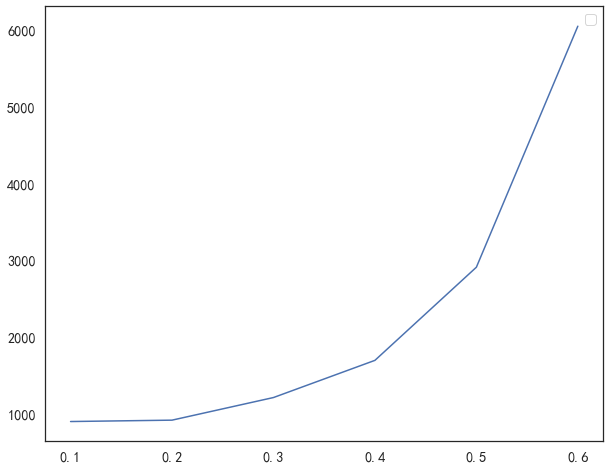

In [538]:
# 做数频率和提效的关系
pt111=pd.pivot_table(data=ball,values='user_erp',index='dtp_pre_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt111.dtp_pre_tag.astype(float),pt111.user_erp)
plt.legend()
plt.show()

## 方式一

筛选方式一：
- 选择事前/事后做数频率、文件量、事前时长和实验组相似的对照样本
- 选择自身时长事后/事前差不多的对照样本

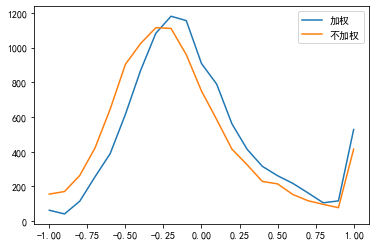

In [359]:
pt1=pd.pivot_table(data=ball,values='user_erp',index='excel_dur_file_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()
pt2=pd.pivot_table(data=ball,values='user_erp',index='excel_dur_file_all_diff_tag',aggfunc=pd.Series.nunique,margins=False).reset_index()

plt.plot(pt1.excel_dur_file_diff_tag.astype(float),pt1.user_erp,label='加权') 
plt.plot(pt2.excel_dur_file_all_diff_tag.astype(float),pt2.user_erp,label='不加权') 
plt.legend() 
plt.show() 

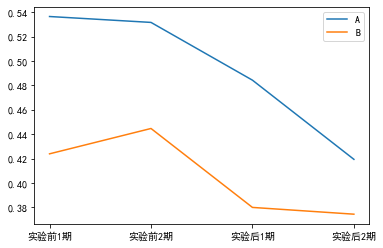

In [358]:
x=['实验前1期','实验前2期','实验后1期','实验后2期']
y1=af3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf2[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

### 自身前后变化不大的样本

In [785]:
# 筛选对照组事前事后相似样本
ball['sim_bb']=ball.apply(lambda x:1 if abs(1-x.excel_dur_file_all_aft_avg/x.excel_dur_file_all_pre_avg)<0.3 else 0,axis=1)
pd.pivot_table(data=ball,values='user_erp',index='sim_bb',aggfunc=pd.Series.nunique,margins=False).reset_index()

sim_bb  user_erp
0       0      7876
1       1      5769

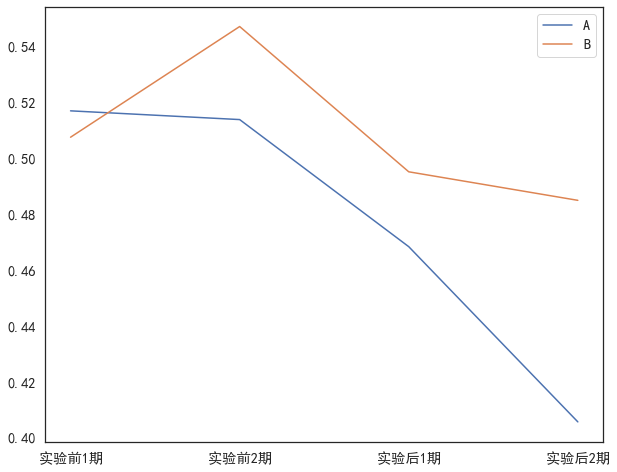

In [688]:
x=['实验前1期','实验前2期','实验后1期','实验后2期']
# y1=af2[af2.excel_dur_file_all_pre_avg>=0.1][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y1=af3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=ball[ball.sim_bb==1][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

In [385]:
# 对照组第一步筛选后样本
bf3_t1=ball[ball.sim_bb==1].reset_index(drop=True)

In [526]:
ball[(ball.sim_bb==1)&(ball.dtp_pre_tag>=0.3)]

label       user_erp if_fg first_visit_date if_lz level_grade  \
1         B        baijia3     0       2999-01-01     1          O2   
3         B   baochaoneng1     0       2999-01-01     1          O2   
5         B    baozhongde1     0       2999-01-01     1          O2   
8         B          bihui     0       2999-01-01     1          O2   
9         B     bijiandong     0       2999-01-01     1          P7   
...     ...            ...   ...              ...   ...         ...   
13632     B       zhucan16     0       2999-01-01     1          O2   
13634     B    zhujinglei3     0       2999-01-01     1          P5   
13638     B      zhuting71     0       2999-01-01     1          P1   
13641     B   zoujianfeng1     0       2999-01-01     1          O2   
13644     B  zuomingguang1     0       2999-01-01     1          O4   

      work_post_name                                  dept_full_name   line  \
1               盘点员岗       京东集团-京东物流-供应链事业部-广东省区-广东深惠市-深圳商超B个护清洁仓1号库  供应链其他   
3               仓管员岗            京东集团-京东物流-快递快运事业部-广西省区-广西东片区-贵港浔州营业部   快快终端   
5              入库组长岗  京东集团-京东物流-供应链事业部-四川省区-四川青白江区-成都米面粮油车旅美妆综合仓-入库组  供应链其他   
8              运作主管岗             京东集团-京东物流-快递快运事业部-江西省区-抚鹰片区-鹰潭月湖营业部   快快终端   
9              销售策略岗                 京东集团-京东物流-供应链事业部-湖北省区-销售部-销售服务组  供应链其他   
...              ...                                             ...    ...   
13632           仓管员岗          京东集团-京东物流-快递快运事业部-湖北省区-汉口片区-武汉汉正街揽收营业部   快快终端   
13634          仓储运营岗                  京东集团-京东物流-供应链事业部-运营改善部-冷链BC运营组  供应链其他   
13638         供应链销售岗               京东集团-京东物流-供应链事业部-陕西省区-销售部-快消行业销售组  供应链其他   
13641           盘点员岗    京东集团-京东物流-供应链事业部-广东省区-广东广州市-广州亚一综合A仓1号库-在库1组  供应链其他   
13644         系统协调员岗       京东集团-京东物流-供应链事业部-江苏省区-江苏服务中心-江苏维修组-维修业务一组    服务+   

      org_busi_group_1 org_busi_group_2 org_busi_group_3 zjxl  \
1               供应链事业部             广东省区            广东深惠市    O   
3              快递快运事业部             广西省区            广西东片区    O   
5               供应链事业部             四川省区           四川青白江区    O   
8              快递快运事业部             江西省区             抚鹰片区    O   
9               供应链事业部             湖北省区              销售部    P   
...                ...              ...              ...  ...   
13632          快递快运事业部             湖北省区             汉口片区    O   
13634           供应链事业部            运营改善部          冷链BC运营组    P   
13638           供应链事业部             陕西省区              销售部    P   
13641           供应链事业部             广东省区            广东广州市    O   
13644           供应链事业部             江苏省区           江苏服务中心    O   

      main_sequnce_descr sequence_descr subsequence_descr first_line  \
1                   操作序列         技能作业序列            技能作业序列        供应链   
3                   操作序列         技能作业序列            技能作业序列       快递快运   
5                   操作序列         技能作业序列            技能作业序列        供应链   
8                   操作序列         快递作业序列            快递作业序列       快递快运   
9                   专业序列           销售序列            商务拓展序列        供应链   
...                  ...            ...               ...        ...   
13632               操作序列         技能作业序列            技能作业序列       快递快运   
13634               专业序列         物流运营序列          物流运营实施序列        供应链   
13638               专业序列           销售序列              销售序列        供应链   
13641               操作序列         技能作业序列            技能作业序列        供应链   
13644               操作序列         综合作业序列            综合作业序列        供应链   

      second_line excel_num  ud_num  ud_num_visit  ud_dt  ud_dt_visit  \
1             常温C         0       0             0      0            0   
3             营业部         0       0             0      0            0   
5             常温C         0       0             0      0            0   
8             营业部         0       0             0      0            0   
9              职能         0       0             0      0            0   
...           ...       ...     ...           ...    ...          ...   
13632         营业部         0       0            

### 对照组和实验组相似的样本

In [539]:
from scipy . spatial . distance import cdist,pdist
import heapq

# 给A组匹配事前相似样本
def simb_pre(a,n):
    w=[2,1,1,1,1]
#     b=bf3_t1[['excel_dur_file_all_pre_avg','excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','dtp_pre','file_pre','dtp_aft','file_aft']]
    b=bf3_t1[bf3_t1.dtp_pre_tag>=0.3][['excel_dur_file_all_pre_avg','excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','dtp_pre','file_pre','dtp_aft','file_aft']]
    t=cdist([a],b) 
    res=t.reshape(-1).tolist()
    smallest=heapq.nsmallest(n, res)
    smallest_ind=[res.index(value) for value in smallest]
#     return smallest_ind,smallest
    return smallest_ind


In [389]:
# 测试验证
a=af3[['excel_dur_file_all_pre_avg','excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','dtp_pre','file_pre','dtp_aft','file_aft']].iloc[0]
smallest_ind,smallest=simb_pre(a,10)
print(smallest)
# print(smallest_ind)
print(af3[['user_erp','excel_dur_file_all_pre_avg','excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft']].iloc[0])
# ttt=bf3_t1[['excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft']].reset_index(drop=True)
bf3_t1[['user_erp','excel_dur_file_all_pre_avg','excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft']].iloc[smallest_ind]

[0.43083972509195134, 0.4399667970039423, 0.46249125003887653, 0.5103579032973042, 0.5377134680307142, 0.569313401043429, 0.5702563510224954, 0.6074568877457436, 0.6363744960873536, 0.6504193562986169]
user_erp                      baimeng5
excel_dur_file_all_pre_avg    0.337748
dtp_pre                       0.233333
file_pre                             8
excel_dur_file_all_aft_avg    0.235722
dtp_aft                       0.271429
file_aft                       5.42105
Name: 2, dtype: object


user_erp  excel_dur_file_all_pre_avg   dtp_pre  file_pre  \
1487     guozehang1                    0.168889  0.100000  8.333333   
5632   wangpengbo19                    0.294861  0.533333  7.812500   
4476   yangjianing7                    0.507222  0.300000  7.777778   
3315  gaoguangyong1                    0.466528  0.533333  8.062500   
4871    xiaoyanming                    0.715278  0.400000  8.000000   
4653      gaowanjun                    0.479722  0.366667  7.636364   
4643    fengzhanjun                    0.216944  0.666667  7.900000   
2530      liuyuezhi                    0.262083  0.666667  7.800000   
345      xueguoxian                    0.621250  0.500000  7.933333   
1159       panfeng9                    0.320694  0.666667  8.350000   

      excel_dur_file_all_aft_avg   dtp_aft  file_aft  
1487                    0.132179  0.107438  5.384615  
5632                    0.258778  0.528926  5.437500  
4476                    0.451997  0.578512  5.228571  
3315                    0.526970  0.595041  5.208333  
4871                    0.541635  0.487603  5.152542  
4653                    0.403569  0.528926  5.125000  
4643                    0.156461  0.578512  5.557143  
2530                    0.197956  0.561983  5.647059  
345                     0.550211  0.644628  5.089744  
1159                    0.274222  0.586777  5.535211

In [820]:
# 正式匹配
af3['smallest_ind']=af3.apply(lambda x:simb_pre([x.excel_dur_file_all_pre_avg,x.excel_dur_file_all_pre_step1,x.excel_dur_file_all_pre_step2,x.dtp_pre,x.file_pre,x.dtp_aft,x.file_aft],15),axis=1) 
# af4['smallest_ind']=af4.apply(lambda x:simb_pre([x.excel_dur_file_all_pre_avg,x.excel_dur_file_all_pre_step1,x.excel_dur_file_all_pre_step2,x.dtp_pre,x.file_pre,x.dtp_aft,x.file_aft],3),axis=1) 


In [822]:
print(len(bf3_t3))
af4.user_erp.nunique()

5380


6068

In [821]:
resb=np.unique(np.array(af3.smallest_ind.to_list()).reshape(-1))
print(len(resb))
# bf3_t2=bf3_t1.iloc[list(resb)]
# bf3_t3=bf3_t1.iloc[list(resb)]
bf3_t5=bf3_t1.iloc[list(resb)]
# bf3_t3

5432


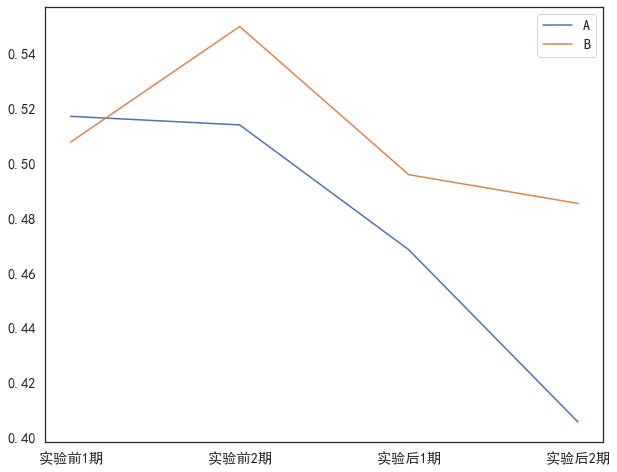

In [725]:
x=['实验前1期','实验前2期','实验后1期','实验后2期']
# y1=af2[af2.excel_dur_file_all_pre_avg>=0.1][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y1=af3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf3_t3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

### 过滤step2比step1差特别多的样本

In [726]:
bf3_t3['step21']=bf3_t3.apply(lambda x:(x.excel_dur_file_all_pre_step2-x.excel_dur_file_all_pre_step1)/(x.excel_dur_file_all_pre_step1+0.000000001),axis=1)


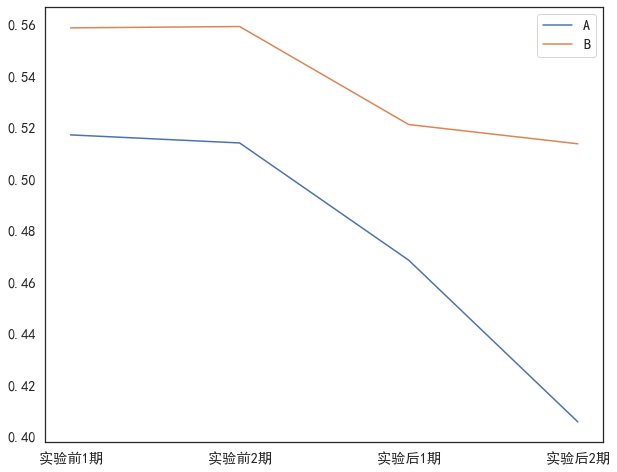

In [779]:
x=['实验前1期','实验前2期','实验后1期','实验后2期']
# y1=af2[af2.excel_dur_file_all_pre_avg>=0.1][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y1=af3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=bf3_t3[bf3_t3.step21<=1.5][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

In [733]:
bf3_t4=bf3_t3[bf3_t3.step21<=1.5] # 加上这个条件少了600样本

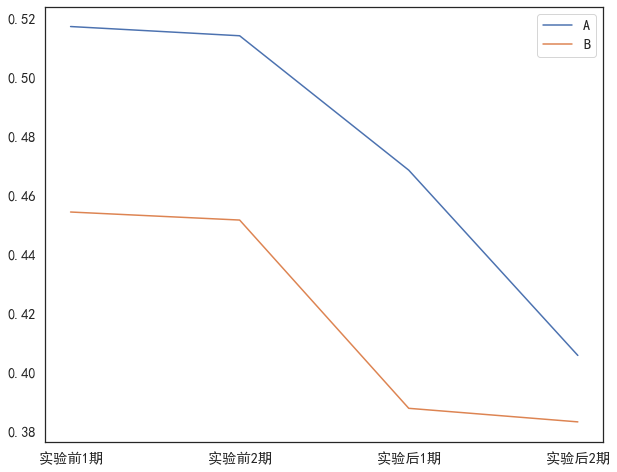

In [794]:
ball['step21']=ball.apply(lambda x:(x.excel_dur_file_all_pre_step2-x.excel_dur_file_all_pre_step1)/(x.excel_dur_file_all_pre_step1+0.000000001),axis=1)

x=['实验前1期','实验前2期','实验后1期','实验后2期']
# y1=af2[af2.excel_dur_file_all_pre_avg>=0.1][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y1=af3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()
y2=ball[ball.step21<=4][['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2']].mean().tolist()

plt.plot(x,y1,label='A')
plt.plot(x,y2,label='B')
plt.legend()
plt.show()

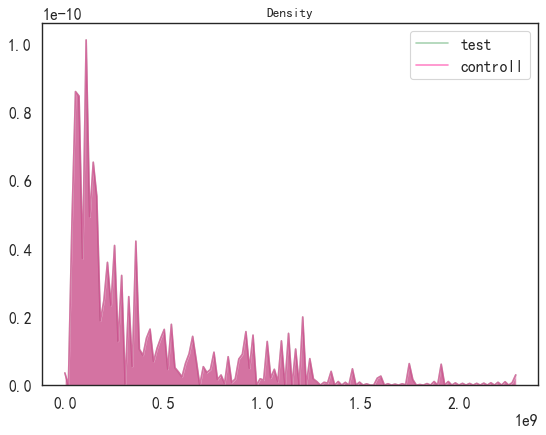

In [796]:
plot_density(ball.step21,ball.step21)

In [800]:
avg=ball.step21.mean()
std=ball.step21.std()
# ball[ball.step21<=avg+std]
std

75813650.01432244

### 过滤表均时长特别长的样本

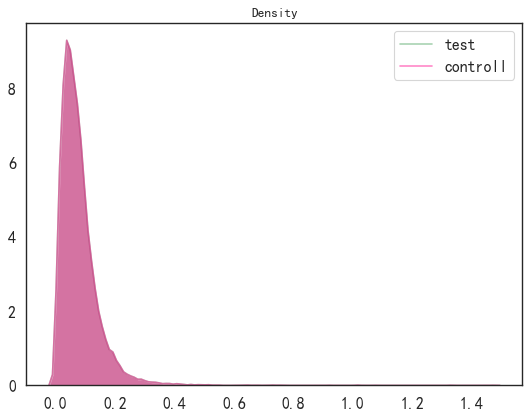

In [837]:
ball['file_time_pre']=ball.excel_dur_file_all_pre_avg/ball.file_pre
plot_density(ball.file_time_pre,ball.file_time_pre)

In [869]:
avg=ball.file_time_pre.mean()
std=ball.file_time_pre.std()
print(avg,'\t',std)
print(avg+std)
print(ball.file_time_pre.quantile([0.25,0.5,0.75]))

0.07859939839596798 	 0.06710195973479821
0.14570135813076618
0.25    0.036699
0.50    0.064312
0.75    0.101559
Name: file_time_pre, dtype: float64


In [868]:
tmp=ball[ball.file_time_pre>0.2]
avg=ball.excel_dur_file_all_pre_avg.mean()
std=ball.excel_dur_file_all_pre_avg.std()
print(avg,'\t',std)
print(len(tmp))
len(ball)

0.43425379056049707 	 0.5084072690543936
577


13645

In [847]:
# ball[ball.file_time_pre>0.4].user_erp.to_list()
ball[ball.file_time_pre>0.4]

label       user_erp if_fg first_visit_date if_lz level_grade  \
329       B    lihongzheng     0       2999-01-01     1          O2   
614       B    shiyaqiang1     0       2024-05-12     1          O2   
695       B    wangjing441     0       2999-01-01     1          O2   
868       B       yinchao9     0       2999-01-01     1          O2   
927       B  yxlihonglin16     0       2999-01-01     1          O2   
...     ...            ...   ...              ...   ...         ...   
12753     B   zhaoshuai102     0       2999-01-01     1          O2   
13071     B    liangqian29     0       2999-01-01     1          P3   
13133     B       liuyina1     0       2999-01-01     1          O2   
13312     B     wangminhai     0       2999-01-01     1          O2   
13644     B  zuomingguang1     0       2999-01-01     1          O4   

      work_post_name                             dept_full_name      line  \
329            运输组长岗        京东集团-京东物流-快递快运事业部-山东省区-短途运力部-鲁东传站车队      快快拣运   
614             调度员岗   京东集团-京东物流-运力平台部-华北运力运营部-北京公路长途运力组-北京支线车队     运力平台部   
695             车管员岗  京东集团-京东物流-运力平台部-苏沪皖运力运营部-沪昆公路长途运力组-沪昆干线车队     运力平台部   
868            运输组长岗        京东集团-京东物流-快递快运事业部-山东省区-短途运力部-鲁南传站车队      快快拣运   
927             盘点员岗         京东集团-京东物流-供应链事业部-贵州省区-贵阳亚一FDC仓-入库组     供应链其他   
...              ...                                        ...       ...   
12753           退货员岗         京东集团-京东物流-快递快运事业部-河北省区-拣运运营部-固安退货组      快快拣运   
13071          客户运维岗   京东集团-京东物流-客户体验与服务部-理赔和专项服务部-武汉分中心-专项服务一组  客户体验与服务部   
13133           分拣员岗    京东集团-京东物流-快递快运事业部-拣运运营部-昆山枢纽-苏州千灯散货分拣中心      快快拣运   
13312          运输组长岗        京东集团-京东物流-快递快运事业部-山东省区-短途运力部-鲁南传站车队      快快拣运   
13644         系统协调员岗  京东集团-京东物流-供应链事业部-江苏省区-江苏服务中心-江苏维修组-维修业务一组       服务+   

      org_busi_group_1 org_busi_group_2 org_busi_group_3 zjxl  \
329            快递快运事业部             山东省区            短途运力部    O   
614              运力平台部          华北运力运营部        北京公路长途运力组    O   
695              运力平台部         苏沪皖运力运营部        沪昆公路长途运力组    O   
868            快递快运事业部             山东省区            短途运力部    O   
927             供应链事业部             贵州省区         贵阳亚一FDC仓    O   
...                ...              ...              ...  ...   
12753          快递快运事业部             河北省区            拣运运营部    O   
13071         客户体验与服务部         理赔和专项服务部            武汉分中心    P   
13133          快递快运事业部            拣运运营部             昆山枢纽    O   
13312          快递快运事业部             山东省区            短途运力部    O   
13644           供应链事业部             江苏省区           江苏服务中心    O   

      main_sequnce_descr sequence_descr subsequence_descr first_line  \
329                 操作序列         运输作业序列            运输作业序列         运力   
614                 操作序列         综合作业序列            综合作业序列         运力   
695                 操作序列         综合作业序列            综合作业序列         运力   
868                 操作序列         运输作业序列            运输作业序列         运力   
927                 操作序列         技能作业序列            技能作业序列        供应链   
...                  ...            ...               ...        ...   
12753               操作序列         售后作业序列            售后作业序列       快递快运   
13071               专业序列         物流运营序列          物流运营实施序列       客户服务   
13133               操作序列         技能作业序列            技能作业序列       快递快运   
13312               操作序列         运输作业序列            运输作业序列         运力   
13644               操作序列         综合作业序列            综合作业序列        供应链   

      second_line excel_num  ud_num  ud_num_visit  ud_dt  ud_dt_visit  \
329            传站         0       0             0      0            0   
614            支线         0       0             0      0            0   
695            干线         0       0             0      0            0   
868            传站         0       0             0      0            0   
927           常温C         0       0             0      0            0   
...           ...       ...     ...           ...    ...          ...   
12753          分拣         0       0             0      0            0  

# 过滤结果合并

记录：     
q4aa3     TOP10      af3     bf3_t3     
q4aa5     TOP15      af3     bf3_t5       f16        
q4aa6     ALL      af3     ball        b组不筛选f15       
q4aa7     TOP10      af3     bf3_t3       b.file_time<0.2 f17



In [871]:
bf3_t3['file_time']=bf3_t3.excel_dur_file_all_pre_avg/bf3_t3.file_pre

In [872]:
res=pd.concat([bf1[bf1.user_erp.isin(bf3_t3[bf3_t3.file_time<0.2].user_erp)],af3])
res['smallest_ind']=0  

In [873]:
res[['label','user_erp','if_fg','first_visit_date','if_lz','level_grade','work_post_name','dept_full_name','line','org_busi_group_1','org_busi_group_2','org_busi_group_3','zjxl','main_sequnce_descr','sequence_descr','subsequence_descr','first_line','second_line','excel_num','ud_dt','ud_num','ud_num_visit','excel_dur_file_aft','excel_dur_file_all_aft','dtp_aft','file_aft','excel_dur_file_aft_step1','excel_dur_file_aft_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2','dtp_aft_step1','dtp_aft_step2','file_aft_step1','file_aft_step2','file_aft_all_step1','file_aft_all_step2','excel_dur_file_pre','excel_dur_file_all_pre','dtp_pre','file_pre','excel_dur_file_pre_step1','excel_dur_file_pre_step2','excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','dtp_pre_step1','dtp_pre_step2','file_pre_step1','file_pre_step2','file_pre_all_step1','file_pre_all_step2','excel_dur_file_aft_avg','excel_dur_file_pre_avg','excel_dur_file_diff','excel_dur_file_diff_pp','excel_dur_file_diff_tag','excel_dur_file_all_aft_avg','excel_dur_file_all_pre_avg','excel_dur_file_all_diff','excel_dur_file_all_diff_pp','excel_dur_file_all_diff_tag','ud_dt_tag','dtp_pre_tag','dtp_aft_tag','dtp_diff','dtp_diff_tag','file_pre_tag','file_aft_tag','file_diff','file_diff_tag','excel_dur_file_all_pre_avg_sd','excel_dur_file_all_aft_avg_sd','file_pre_sd','file_aft_sd','dtp_pre_sd','dtp_aft_sd','smallest_ind']].to_csv('../data/q4aa7.csv',sep='\t',header=False,index=False)
# !hive -e "load data local inpath '../data/q4aa5.csv' overwrite into table tmp.tmp_zl_udata_ab_24q1_aa;"
!hive -e "load data local inpath '../data/q4aa7.csv' overwrite into table tmp.tmp_zl_udata_ab_24q1_aa_bk;"



HiveTask: The return code by executing engine tools is 1
log4j:ERROR setFile(null,true) call failed.
java.io.FileNotFoundException: /data0/Logs/mart_coo/hive-0.12.0/hive.log (权限不够)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(FileOutputStream.java:270)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:133)
	at org.apache.log4j.FileAppender.setFile(FileAppender.java:294)
	at org.apache.hive.common.FilePermissionDailyRollingFileAppender.setFile(FilePermissionDailyRollingFileAppender.java:33)
	at org.apache.log4j.FileAppender.activateOptions(FileAppender.java:165)
	at org.apache.log4j.DailyRollingFileAppender.activateOptions(DailyRollingFileAppender.java:223)
	at org.apache.log4j.config.PropertySetter.activate(PropertySetter.java:307)
	at org.apache.log4j.config.PropertySetter.setProperties(PropertySetter.java:172)
	at org.apache.log4j.config.PropertySetter.setProperties(PropertyS

In [848]:
ball

label       user_erp if_fg first_visit_date if_lz level_grade  \
0         B       anzhigao     0       2999-01-01     1         ST4   
1         B        baijia3     0       2999-01-01     1          O2   
2         B     baijunjie3     0       2999-01-01     1          P3   
3         B   baochaoneng1     0       2999-01-01     1          O2   
4         B       baoying7     0       2999-01-01     1          P4   
...     ...            ...   ...              ...   ...         ...   
13640     B  zouguangming1     0       2999-01-01     1          P6   
13641     B   zoujianfeng1     0       2999-01-01     1          O2   
13642     B    zoukaipeng1     0       2999-01-01     1          O2   
13643     B       zoutong7     0       2999-01-01     1          P6   
13644     B  zuomingguang1     0       2999-01-01     1          O4   

      work_post_name                                dept_full_name    line  \
0              设备组长岗             京东集团-京东物流-供应链事业部-江苏省区-运营改善部-设备服务组   供应链其他   
1               盘点员岗     京东集团-京东物流-供应链事业部-广东省区-广东深惠市-深圳商超B个护清洁仓1号库   供应链其他   
2             供应链销售岗              京东集团-京东物流-供应链事业部-北京区-销售部-医药行业销售组   供应链其他   
3               仓管员岗          京东集团-京东物流-快递快运事业部-广西省区-广西东片区-贵港浔州营业部    快快终端   
4              能力提升岗             京东集团-京东物流-供应链事业部-广东省区-运营改善部-能力提升组   供应链其他   
...              ...                                           ...     ...   
13640          方案实施岗            京东集团-京东物流-供应链事业部-江苏省区-产品方案部-行业方案一组   供应链其他   
13641           盘点员岗  京东集团-京东物流-供应链事业部-广东省区-广东广州市-广州亚一综合A仓1号库-在库1组   供应链其他   
13642        营业部负责人岗        京东集团-京东物流-快递快运事业部-湖南省区-长沙东片区-长沙汽车东站营业部    快快终端   
13643          系统实施岗                  京东集团-京东物流-行业大客户部-解决方案部-系统实施组  行业大客户部   
13644         系统协调员岗     京东集团-京东物流-供应链事业部-江苏省区-江苏服务中心-江苏维修组-维修业务一组     服务+   

      org_busi_group_1 org_busi_group_2 org_busi_group_3 zjxl  \
0               供应链事业部             江苏省区            运营改善部   ST   
1               供应链事业部             广东省区            广东深惠市    O   
2               供应链事业部              北京区              销售部    P   
3              快递快运事业部             广西省区            广西东片区    O   
4               供应链事业部             广东省区            运营改善部    P   
...                ...              ...              ...  ...   
13640           供应链事业部             江苏省区            产品方案部    P   
13641           供应链事业部             广东省区            广东广州市    O   
13642          快递快运事业部             湖南省区            长沙东片区    O   
13643           行业大客户部            解决方案部            系统实施组    P   
13644           供应链事业部             江苏省区           江苏服务中心    O   

      main_sequnce_descr sequence_descr subsequence_descr first_line  \
0                   操作序列         技术作业序列            技术作业序列        供应链   
1                   操作序列         技能作业序列            技能作业序列        供应链   
2                   专业序列           销售序列              销售序列        供应链   
3                   操作序列         技能作业序列            技能作业序列       快递快运   
4                   专业序列         业务运营序列            业务支持序列        供应链   
...                  ...            ...               ...        ...   
13640               专业序列       物流产品服务序列          技术产品服务序列        供应链   
13641               操作序列         技能作业序列            技能作业序列        供应链   
13642               操作序列         快递作业序列            快递作业序列       快递快运   
13643               专业序列       物流产品服务序列          技术产品服务序列         销售   
13644               操作序列         综合作业序列            综合作业序列        供应链   

      second_line excel_num  ud_num  ud_num_visit  ud_dt  ud_dt_visit  \
0              职能         0       0             0      0            0   
1             常温C         0       0             0      0            0   
2              职能         0       0             0      0            0   
3             营业部         0       0             0      0            0   
4              职能         0       0             0      0            0   
...           ...       ...     ...           ...    ...          ...   
13640          职能         0       0             0      0   

# 差异检验

In [312]:
# 显著性检验
def aatest(a,b,cols):
    print('字段\t\t实验组均值\t对照组均值\t p')
    for col in cols:
        _, p = ttest_ind(a[col], b[col])
        am=a[col].mean()
        bm=b[col].mean()
        print(str(col)+'\t'+str(round(am,4))+'\t'+str(round(bm,4))+'\t'+str(round(p,4)))

# 概率密度分布图
def plot_density(a,b):
    plt.figure(figsize=(8,6), dpi= 80)

    #通过参数shade的值是True还是False来进行是否填充颜色的操作
    sns.kdeplot(a, shade=True, color="g", label="test", alpha=.5)
    sns.kdeplot(b, shade=True, color="deeppink", label="controll", alpha=.5)

    # Decoration
    plt.title('Density', fontsize=12)
    plt.legend()
    plt.show()

### 神机初步匹配结果

In [853]:
a=af3[af3.user_erp.isin(ab[ab.group_code=='A'].sample_id)]
# b=bf3_t2[bf3_t2.user_erp.isin(ab[ab.group_code=='B'].sample_id)]
b=pd.merge(ab[ab.group_code=='B'],ball,how='left',left_on='sample_id',right_on='user_erp')
aatest(a,b,['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2','excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft'])


字段		实验组均值	对照组均值	 p
excel_dur_file_all_pre_step1	0.517	0.5557	0.0002
excel_dur_file_all_pre_step2	0.5138	0.5645	0.0
excel_dur_file_all_aft_step1	0.4683	0.4852	0.0676
excel_dur_file_all_aft_step2	0.4056	0.453	0.0
excel_dur_file_all_pre_avg	0.5154	0.5601	0.0
dtp_pre	0.5692	0.5551	0.0
file_pre	8.1709	8.4854	0.0067
excel_dur_file_all_aft_avg	0.4369	0.4691	0.0002
dtp_aft	0.5222	0.5083	0.0
file_aft	7.9308	7.2919	0.0


实验前后时长较符合预期，问题主要在于PSM匹配不到合适的样本。接下来要探索PSM匹配的机制。

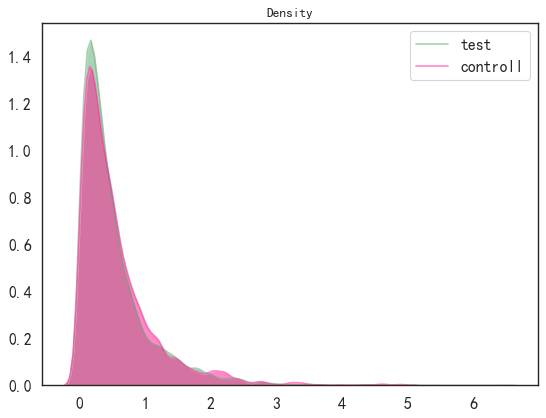

In [854]:
plot_density(a.excel_dur_file_all_pre_avg,b.excel_dur_file_all_pre_avg)

### 神机匹配前的检验结果

In [833]:
b=bf1[bf1.user_erp.isin(bf3_t5.user_erp)]
a=af3
a['file_time_pre']=a.excel_dur_file_all_pre_avg/a.file_pre
b['file_time_pre']=b.excel_dur_file_all_pre_avg/b.file_pre
aatest(a,b,['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2','excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft','file_time_pre'])

字段		实验组均值	对照组均值	 p
excel_dur_file_all_pre_step1	0.517	0.5079	0.3865
excel_dur_file_all_pre_step2	0.5138	0.5494	0.0008
excel_dur_file_all_aft_step1	0.4683	0.4957	0.0048
excel_dur_file_all_aft_step2	0.4056	0.4857	0.0
excel_dur_file_all_pre_avg	0.5154	0.5287	0.1866
dtp_pre	0.5692	0.5539	0.0
file_pre	8.1709	5.7259	0.0
excel_dur_file_all_aft_avg	0.4369	0.4907	0.0
dtp_aft	0.5222	0.5236	0.5918
file_aft	7.9308	5.5369	0.0
file_time_pre	0.0638	0.0874	0.0


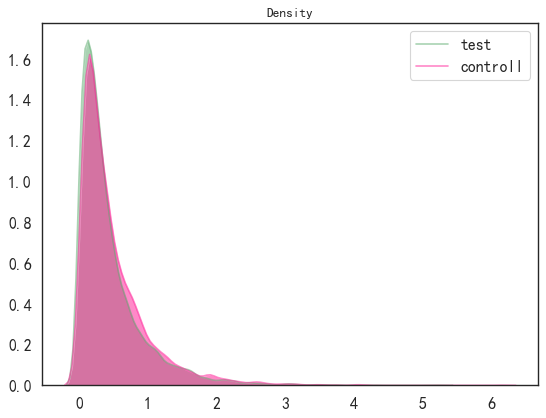

In [827]:
plot_density(a.excel_dur_file_all_aft_avg,b.excel_dur_file_all_aft_avg)

对照组做数频率异常，基本都小于0.2
—— 加工逻辑有问题，已修改

## PSM

In [406]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [503]:
# 加快匹配速度
def find_closest_number(target_number, list_of_numbers):
    """
    在列表中找到最接近目标数字的数字。
    如果有两个数字都是最接近的，返回它们中的较小值。
    """
    closest_number = min(list_of_numbers, key=lambda x: abs(x - target_number))
    return closest_number


In [828]:
# res是经过精确筛选的结果
df=pd.concat([bf3_t4,af3])
df['treatment'] = df['label'].replace({'A':1,'B':0})

psm = PsmPy(df[['user_erp','excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','file_pre','file_aft','treatment']], 
            treatment='treatment', indx='user_erp', exclude = [])

psm.logistic_ps(balance=True) # 计算得分
print('得分计算完成!')
# psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None) # 匹配
# psm.plot_match(Title='Matching Result', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])
# psm.df_matched

# 自定义快速匹配
pres=psm.predicted_data
pres_ab=pres[pres.treatment==1].copy()
pres_b=pres[(pres.treatment==0)]
pres_ab['match_id']=pres_ab.propensity_logit.apply(lambda x:find_closest_number(x,pres_b.propensity_logit) )
# 关联对照组ID
pres_ab=pd.merge(pres_ab,pres_b[['user_erp','propensity_logit']].rename(columns={'user_erp':'match_erp','propensity_logit':'match_id'}),
         how='left',left_on='match_id',right_on='match_id')

得分计算完成!


In [829]:
# 查看匹配效果
res_a=pd.merge(pres_ab[['user_erp']],af1,how='left',on='user_erp')
res_b=pd.merge(pres_ab[['match_erp']].rename(columns={'match_erp':'user_erp'}),bf1,how='left',on='user_erp')
# res_b=pd.merge(psm_res[~pd.isna(psm_res.matched_ID)][['matched_ID']],psm_res,how='left',left_on='matched_ID',right_on='user_erp')

# res_a=psm_res[~pd.isna(psm_res.matched_ID)]
aatest(res_a,res_b,['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2','excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft'])


字段		实验组均值	对照组均值	 p
excel_dur_file_all_pre_step1	0.517	0.5775	0.0
excel_dur_file_all_pre_step2	0.5138	0.5778	0.0
excel_dur_file_all_aft_step1	0.4683	0.5523	0.0
excel_dur_file_all_aft_step2	0.4056	0.5278	0.0
excel_dur_file_all_pre_avg	0.5154	0.5777	0.0
dtp_pre	0.5692	0.5871	0.0
file_pre	8.1709	8.6347	0.0
excel_dur_file_all_aft_avg	0.4369	0.54	0.0
dtp_aft	0.5222	0.5617	0.0
file_aft	7.9308	8.2142	0.0065


In [755]:
tmp=pd.merge(pres_ab,af3[['user_erp','excel_dur_file_all_pre_avg']],how='left',on='user_erp')
tmp=pd.merge(tmp,bf3_t4[['user_erp','excel_dur_file_all_pre_avg','file_pre','dtp_pre','file_aft','dtp_aft']],how='left',left_on='match_erp',right_on='user_erp')
tmp

user_erp_x  excel_dur_file_all_pre_step1  excel_dur_file_all_pre_step2  \
0        baimeng5                      0.382639                      0.292857   
1      baojungang                      0.360556                      0.371944   
2       baowenyi1                      0.322222                      0.189394   
3          bazhu1                      0.048611                      0.131313   
4         bfbzhzh                      0.199306                      0.115476   
...           ...                           ...                           ...   
6540  zhuozhifeng                      0.124722                      0.193434   
6541     zhuqi111                      0.468939                      0.468687   
6542  zhuxingquan                      0.328030                      0.359848   
6543    zouboping                      1.109091                      0.179398   
6544      zouqi44                      0.232778                      0.214394   

      dtp_pre_x  file_pre_x  dtp_aft_x  file_aft_x  propensity_score  \
0      0.233333    8.000000   0.271429    5.421053          0.666367   
1      0.566667   11.352941   0.646018    8.835616          0.622694   
2      0.666667    8.350000   0.646465    5.906250          0.502263   
3      0.633333    2.263158   0.360465    1.774194          0.476898   
4      0.500000    3.466667   0.617647    3.095238          0.351442   
...         ...         ...        ...         ...               ...   
6540   0.700000    4.476190   0.494505    3.666667          0.491231   
6541   0.733333    8.272727   0.617647    8.571429          0.564188   
6542   0.733333   10.772727   0.617647   12.666667          0.745883   
6543   0.500000    6.066667   0.506024    7.666667          0.501705   
6544   0.566667    1.352941   0.494845    1.562500          0.349140   

      propensity_logit  treatment  match_id     match_erp  \
0             0.691801          1  0.691660     gudisheng   
1             0.501001          1  0.501013     gaoxiaxia   
2             0.009050          1  0.008626   fengjiahui5   
3            -0.092473          1 -0.092389    chenlei746   
4            -0.612709          1 -0.612538    hexuemei24   
...                ...        ...       ...           ...   
6540         -0.035080          1 -0.035056   lixiangyue3   
6541          0.258176          1  0.258064    zhangyanan   
6542          1.076773          1  1.076403  liushandong1   
6543          0.006820          1  0.006893   leijiangtao   
6544         -0.622821          1 -0.622808   hechuanrong   

      excel_dur_file_all_pre_avg_x    user_erp_y  \
0                         0.337748     gudisheng   
1                         0.366250     gaoxiaxia   
2                         0.255808   fengjiahui5   
3                         0.089962    chenlei746   
4                         0.157391    hexuemei24   
...                            ...           ...   
6540                      0.159078   lixiangyue3   
6541                      0.468813    zhangyanan   
6542                      0.343939  liushandong1   
6543                      0.644245   leijiangtao   
6544                      0.223586   hechuanrong   

      excel_dur_file_all_pre_avg_y  file_pre_y  dtp_pre_y  file_aft_y  \
0                         0.624306   10.058824   0.566667   10.859375   
1                         0.474861   10.588235   0.566667    9.250000   
2                         0.226806    5.850000   0.666667    6.936709   
3                         1.178611   10.100000   0.666667   11.000000   
4                         0.495139    3.300000   0.666667    3.222222   
...                            ...         ...        ...         ...   
6540                      1.139167   10.850000   0.666667   11.112500   
6541                      0.735000    8.625000   0.533333    8.700000   
6542                      0.277500   12.714286   0.466667   10.600000   
6543                      0.267500    6.650000   0.666667    6.333333   
6544    

In [765]:
# 验证匹配异常的实验组是否偏差较大
tmp

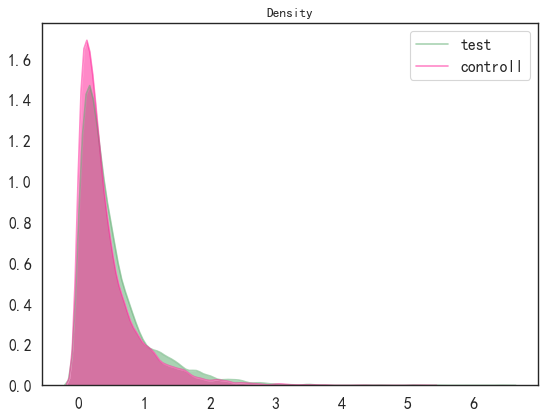

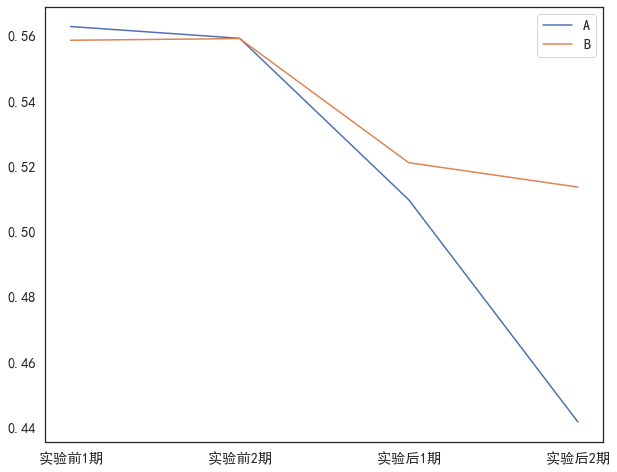

In [482]:
psm_res=psm.df_matched
res_b=bf1[bf1.user_erp.isin(psm.matched_ids.user_erp)]
# res_b=pd.merge(psm_res[~pd.isna(psm_res.matched_ID)][['matched_ID']],psm_res,how='left',left_on='matched_ID',right_on='user_erp')
res_a=af3[af3.user_erp.isin(psm.matched_ids.matched_ID)]
# res_a=psm_res[~pd.isna(psm_res.matched_ID)]
aatest(res_a,res_b,['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2','excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft'])

字段		实验组均值	对照组均值	 p
excel_dur_file_all_pre_step1	nan	nan	nan
excel_dur_file_all_pre_step2	nan	nan	nan
excel_dur_file_all_aft_step1	nan	nan	nan
excel_dur_file_all_aft_step2	nan	nan	nan
excel_dur_file_all_pre_avg	nan	nan	nan
dtp_pre	nan	nan	nan
file_pre	nan	nan	nan
excel_dur_file_all_aft_avg	nan	nan	nan
dtp_aft	nan	nan	nan
file_aft	nan	nan	nan


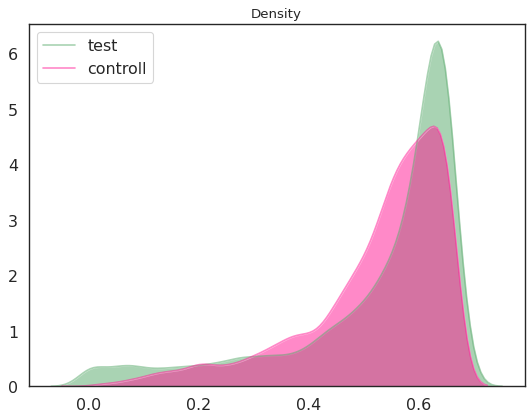

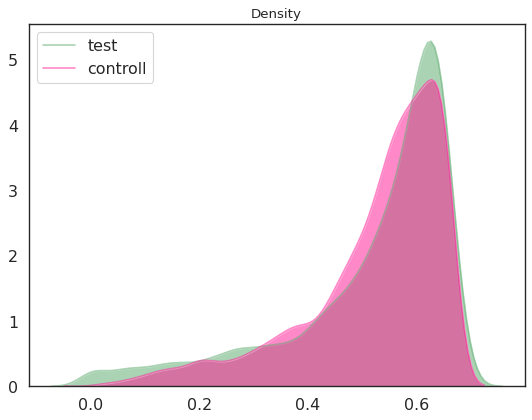

In [454]:
plot_density(a.dtp_aft,b.dtp_aft)
plot_density(res_a.dtp_aft,res_b.dtp_aft)

In [ ]:
import psmatching.match as psm
 
#文件路径，文件需要是csv格式，列命名时需注意：干预组的列名为 CASE ，每个样本id的列名为 OPTUM_LAB_ID，且为数字，自变量最好是英文名
path="psm_test_data.csv" 

formu='CASE ~ Account + BD + Content + Digital_Product + Food_Delivery + General + General_know_how + Insurance + Investment_Product + Logistics + Marketing + Mitra_Shopee + Others + Return_Refund + SPX + SPX_Instant + SPX_Sameday_food + SPayLater_other_credit + Seller_Operations + Shopee_Payment + ShopeePay + ShopeePay_Merchant + WMSLite + have_work_days + total_session_num'
#为每个干预样本匹配1个相似的样本
k = "1"
#初始化模型
model = psm.PSMatch(path, formu, k)
#为所有样本计算倾向得分，为匹配做准备,该流程结束后，model .df中的每一个样本获取了自己的倾向得分
model.prepare_data()

#进行匹配
model.match(caliper = None, replace = False)
#上述结束后，可通过model.matches查看为每个干预组样本的匹配到的对照组id是什么，也可通过model.matched_data查看干预组和新的对照组的集合
matches=model.matches
matched_data=model.matched_data
#通过新的集合，通过卡方检验查看自变量和干预组是否是独立的,卡放检验的逻辑

In [289]:
import statsmodels.stats.weightstats
low=-0.3
upp=0.3
statsmodels.stats.weightstats.ttost_ind(a.excel_dur_file_all_pre_avg, b.excel_dur_file_all_pre_avg, low, upp, usevar='pooled', 
                                        weights=(None, None), transform=None)

(0.0015689102212117446,
 (71.09556377736556, 0.0, 12512.0),
 (-2.9544776805849122, 0.0015689102212117446, 12512.0))

In [285]:
statsmodels.stats.weightstats.ttost_ind(b.file_aft,a.file_aft, low, upp, usevar='pooled', 
                                        weights=(None, None), transform=None)

(0.9999999209551367,
 (-5.245865342458658, 0.9999999209551367, 12512.0),
 (-12.714071213334373, 4.170963718682795e-37, 12512.0))

In [94]:
bf3[['excel_dur_file_all_pre_step1','excel_dur_file_all_pre_step2','excel_dur_file_all_aft_step1','excel_dur_file_all_aft_step2','excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft']].iloc[489]

excel_dur_file_all_pre_step1    3.871111
excel_dur_file_all_pre_step2    1.793611
excel_dur_file_all_aft_step1    3.462569
excel_dur_file_all_aft_step2    3.089341
excel_dur_file_all_pre_avg      2.832361
dtp_pre                         0.123967
file_pre                        2.133333
excel_dur_file_all_aft_avg      3.275955
dtp_aft                         0.561983
file_aft                        2.308824
Name: 489, dtype: float64

In [83]:
af2['is_bb']=af2.apply(lambda x:True if 120 in x.smallest_ind else False,axis=1)
af2[af2.is_bb]

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


label           user_erp first_visit_date if_lz level_grade  \
315       A        chendonghu1       2024-01-14     1          O2   
718       A          dingfei25       2024-01-27     1          P7   
740       A       dingtinglin1       2024-02-01     1          O2   
875       A          fangweili       2024-01-25     1          P6   
973       A         fuyunzhong       2024-02-13     1          O2   
1370      A         heshiling1       2024-02-05     1          O2   
1477      A        huangjiahua       2024-01-21     1          M1   
1672      A            huwumei       2024-02-04     1          O2   
1973      A      liangbeisheng       2024-01-29     1          M1   
2612      A         liulijun39       2024-01-30     1          O2   
2903      A          liyangjia       2024-02-06     1          O2   
3187      A            lvqili1       2024-01-16     1          O2   
3209      A             mabo24       2024-02-11     1          O2   
3300      A          mayanwei1       2024-01-24     1          O2   
3610      A          qiujunyan       2024-03-11     1          P3   
5075      A        xiatongbing       2024-03-28     1          M1   
5825      A          yuwenqian       2024-02-29     1          O2   
5940      A            yxborui       2024-01-22     1          O3   
6097      A         yxwangzubi       2024-03-21     1          P4   
6619      A         zhangyi353       2024-01-10     1          P5   
6930      A             zhiji1       2024-03-21     1          P6   
6957      A     zhongqingqing3       2024-01-16     1          O4   
7363      A          cailimin1       2024-01-25     1          O2   
7765      A       chenyuyang11       2024-01-13     1          M1   
7874      A          danyaping       2024-03-01     1          O2   
8318      A          guanxing8       2024-03-21     1          P4   
8426      A             guqin3       2024-02-20     1          P6   
8661      A         huanggan24       2024-01-09     1          P5   
8942      A       jiangyingri1       2024-03-13     1          P4   
9463      A        linguoqing6       2024-03-29     1          P2   
10001     A        liyanping34       2024-03-05     1          P5   
10284     A           lvxuebin       2024-03-25     1          M1   
12389     A       xulingling26       2024-01-10     1          P5   
12881     A          yuewannan       2024-01-29     1          P4   
13086     A       yxhanjiageng       2024-01-22     1          O2   
13599     A         zhangqi292       2024-03-21     1          P3   
14108     A       zhoudandan33       2024-03-14     1          P3   
15797     A    huangjianqiang5       2024-01-24     1          M1   
15869     A      huangxiaoying       2024-01-11     1          O2   
15880     A     huangyanping19       2024-02-01     1          O2   
16335     A           lidan358       2024-01-19     1          P5   
17276     A             luya97       2024-03-28     1          P6   
17303     A         lvhailong1       2024-03-14     1          O2   
18113     A         sunleiyang       2024-01-12     1          M2   
18203     A      tangliangfeng       2024-03-21     1          P6   
19152     A        xiahangfei1       2024-01-10     1          O3   
19999     A  yx.zhangxiaojiang       2024-03-13     1          O2   
20798     A        zhangyue527       2024-03-21     1          P5   
20913     A         zhaomin146       2024-02-07     1          O2   
21547     A       chenyaqian19       2024-03-27     1          O2   
23320     A          zhanglu68       2024-03-03     1          P5   

      work_post_name                                dept_full_name      line  \
315            分拣组长岗        京东集团-京东物流-快递快运事业部-北京区-拣运运营部-北京天河散货分拣中心      快快拣运   
718            经营改善岗             京东集团-京东物流-供应链事业部-广东省区-综合支持部-经营分析组     供应链其他   
740             车管员岗        京东集团-京东物流-快递快运事业部-上海区-短途运力部-上海嘉定传站第二车队      快快拣运   
875            经营分析岗            京东集团-京东物流-快递快运事业部-陕西省区-综合支持组-经营分析组      综合支持   
973            分拣

In [97]:
bf3[bf3.file_pre>=25]

label        user_erp first_visit_date if_lz level_grade work_post_name  \
136      B      chenyong81       2024-01-01     1          O3           仓管员岗   
235      B      fuzhiqiang       2024-01-01     1          O2          运作主管岗   
237      B       gandeming       2024-01-01     1          M1    营业部负责人岗(业务)   
518      B     lishaojie10       2024-01-01     1          O2          分拣组长岗   
564      B    liulongxiang       2024-01-01     1          O2        营业部负责人岗   
687      B  mengxiangchen6       2024-01-01     1          O2           专服员岗   
692      B         moudan1       2024-01-01     1          O2           分拣员岗   
1066     B       xujiahao6       2024-01-01     1          O2          运作主管岗   
1211     B    yxdaitianyou       2024-01-01     1          P4          片区支持岗   
1282     B    zhangchao340       2024-01-01     1          M1     机构负责人岗(通用)   
1819     B     jiangmeng27       2024-01-01     1          O2         分拣操作员岗   
2142     B    mengxianling       2024-01-01     1          O2         工单处理员岗   
2305     B     taoshaopeng       2024-01-01     1          M1    营业部负责人岗(业务)   
2391     B       wangyan52       2024-01-01     1          O2          装车组长岗   
2471     B        wuyong35       2024-01-01     1          M1    营业部负责人岗(业务)   
2991     B         cdzhaow       2024-01-01     1          O3           验收员岗   
3838     B      tangyong20       2024-01-01     1          O2           仓管员岗   
3939     B       wangyunfa       2024-01-01     1          M2    营业部负责人岗(业务)   
3985     B         wudegao       2024-01-01     1          M1    营业部负责人岗(业务)   
4086     B     yanghaibo12       2024-01-01     1          M1    营业部负责人岗(业务)   
4824     B     yaoguangcan       2024-01-01     1          O2          装车组长岗   

                                    dept_full_name   line org_busi_group_1  \
136   京东集团-京东物流-供应链事业部-广东省区-广东逆向中心-广州逆向仓-广州中件逆向在库组  供应链其他           供应链事业部   
235           京东集团-京东物流-快递快运事业部-北京区-将台片区-北京京艺天朗营业部   快快终端          快递快运事业部   
237            京东集团-京东物流-快递快运事业部-江西省区-宜萍片区-宜春高安营业部   快快终端          快递快运事业部   
518   京东集团-京东物流-快递快运事业部-广东省区-拣运运营部-东莞亚一分拣中心-分拣作业二组   快快拣运          快递快运事业部   
564            京东集团-京东物流-快递快运事业部-江西省区-赣州片区-赣州蟠龙营业部   快快终端          快递快运事业部   
687            京东集团-京东物流-快递快运事业部-河南省区-郑东片区-开封汴京营业部   快快终端          快递快运事业部   
692        京东集团-京东物流-快递快运事业部-拣运运营部-昆山枢纽-苏州千灯散货分拣中心   快快拣运          快递快运事业部   
1066         京东集团-京东物流-快递快运事业部-广东省区-佛山顺德片区-佛山碧江营业部   快快终端          快递快运事业部   
1211                   京东集团-京东物流-快递快运事业部-江西省区-赣东片区   快快其他          快递快运事业部   
1282     京东集团-京东物流-供应链事业部-天津区-天津武清区-天津雀巢KA仓1号库-出库组  供应链其他           供应链事业部   
1819     京东集团-京东物流-供应链事业部-湖北省区-湖北大件中心-孝感大件DC-平台分拣组     大件           供应链事业部   
2142       京东集团-京东物流-供应链事业部-天津区-天津冷链医药中心-天津冷链B仓1号库  供应链其他           供应链事业部   
2305           京东集团-京东物流-快递快运事业部-河南省区-郑南片区-郑州建业营业部   快快终端          快递快运事业部   
2391        京东集团-京东物流-快递快运事业部-上海区-拣运运营部-上海嘉定集货分拣中心   快快拣运          快递快运事业部   
2471          京东集团-京东物流-快递快运事业部-湖南省区-长沙东片区-长沙隆平营业部   快快终端          快递快运事业部   
2991    京东集团-京东物流-供应链事业部-四川省区-四川逆向中心-成都逆向仓-小件逆向在库组  供应链其他           供应链事业部   
3838           京东集团-京东物流-快递快运事业部-江苏省区-太仓片区-常熟莫南营业部   快快终端          快递快运事业部   
3939          京东集团-京东物流-快递快运事业部-广东省区-广州北片区-广州炭步营业部   快快终端          快递快运事业部   
3985         京东集团-京东物流-快递快运事业部-江西省区-南昌南片区-南昌进贤东营业部   快快终端          快递快运事业部   
4086           京东集团-京东物流-快递快运事业部-江苏省区-盐泰片区-盐城响水营业部   快快终端          快递快运事业部   
4824   京东集团-京东物流-快递快运事业部-广东省区-拣运运营部-东莞亚一分拣中心-装车作业组   快快拣运          快递快运事业部   

     org_busi_group_2 org_busi_group_3 zjxl main_sequnce_descr sequence_descr  \
136              广东省区           广东逆向中心    O               操作序列         技能作业序列   
235               北京区             将台片区    O               操作序列         快递作业序列   
237              江西省区             宜萍片区    M               管理序列         业务管理序列   
518              广东省区            拣运运营部    O               操作序列         技能作业序列   
564              江西省区             赣州片区    O               操作序列         快递作业序列   
687              河南省区             郑东片区   

In [362]:
ttt=ball[ball.sim_bb==1][['excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_aft_avg','dtp_aft','file_aft']].reset_index(drop=True)
ttt[ttt.excel_dur_file_all_pre_avg<0.1]

excel_dur_file_all_pre_avg   dtp_pre  file_pre  \
40                      0.083750  0.140496  1.764706   
57                      0.099028  0.115702  2.285714   
59                      0.065417  0.115702  2.642857   
85                      0.088472  0.115702  2.000000   
96                      0.051806  0.157025  1.894737   
...                          ...       ...       ...   
4901                    0.028194  0.115702  1.642857   
4907                    0.014444  0.132231  1.250000   
4920                    0.082917  0.107438  2.153846   
4921                    0.066389  0.148760  1.722222   
4926                    0.069583  0.165289  3.150000   

      excel_dur_file_all_aft_avg   dtp_aft  file_aft  
40                      0.073711  0.429752  1.961538  
57                      0.124849  0.413223  2.360000  
59                      0.078883  0.363636  2.840909  
85                      0.072397  0.272727  1.939394  
96                      0.047592  0.438017  2.000000  
...                          ...       ...       ...  
4901                    0.026526  0.388430  2.234043  
4907                    0.010414  0.314050  1.236842  
4920                    0.094795  0.520661  2.190476  
4921                    0.062902  0.479339  2.465517  
4926                    0.089272  0.652893  3.873418  

[326 rows x 6 columns]

In [391]:
z=np.vstack([y[1],x])
pdist(z) 

array([1.])

In [390]:
y = np.array([[2, 0, 2], 
              [2, 2, 3], 
              [-2, 4, 5], 
              [0, 1, 9], 
              [2, 2, 4]])
x=[1,2,3]
res=cdist([x],y)
print(res)
res=res.reshape(-1).tolist()
smallest=heapq.nsmallest(10, res)
smallest_ind=[res.index(value) for value in smallest]
print(smallest)
smallest_ind

[[2.44948974 1.         4.12310563 6.164414   1.41421356]]
[1.0, 1.4142135623730951, 2.449489742783178, 4.123105625617661, 6.164414002968976]


[1, 4, 0, 2, 3]

In [379]:
b=af2[['excel_dur_file_all_pre_avg_sd','dtp_pre_sd','file_pre_sd']].iloc[0]
a=ball[['excel_dur_file_all_pre_avg_sd','dtp_pre_sd','file_pre_sd']]
# res=np.dot(a,b)/(np.linalg.norm(a,axis=1)*np.linalg.norm(b)) 
res1=cdist(a,[b]) 

In [380]:
res1=res1.reshape(-1).tolist()
smallest=heapq.nsmallest(10, res1)
smallest_ind=[res1.index(value) for value in smallest]
print(smallest)
smallest_ind

[0.4757386815209468, 0.4779720360665353, 0.47892678444713027, 0.4791556641392186, 0.4798114687869767, 0.4800870867004622, 0.4813398867334153, 0.48928926701434844, 0.4893916780226003, 0.4903347428788155]


[6708, 6230, 68, 7999, 873, 5717, 7772, 6305, 786, 2663]

In [346]:
a=af2[['excel_dur_file_all_pre_avg_sd','dtp_pre_sd','file_pre_sd']].iloc[0]
b=ball[['excel_dur_file_all_pre_avg_sd','dtp_pre_sd','file_pre_sd']]
res2=cdist([a],b)

In [363]:
res2=res2.reshape(-1).tolist()
smallest=heapq.nsmallest(10, res2)
smallest_ind=[res2.index(value) for value in smallest]
smallest_ind

[6708, 6230, 68, 7999, 873, 5717, 7772, 6305, 786, 2663]

In [377]:
a=ball[['excel_dur_file_all_pre_avg','dtp_pre','file_pre']].iloc[6708]
x=np.vstack([a,b])
pdist(x) 

array([7.18869375])

In [315]:
ball[['excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_pre_avg_sd','dtp_pre_sd','file_pre_sd']].iloc[smallest_ind]

excel_dur_file_all_pre_avg   dtp_pre  file_pre  \
6708                    0.881667  0.165289      8.60   
6230                    0.894583  0.165289      8.85   
68                      0.908472  0.165289      8.65   
7999                    0.879028  0.165289      8.90   
873                     0.861250  0.165289      8.65   
5717                    0.880417  0.165289      8.40   
7772                    0.858333  0.165289      8.75   
6305                    0.891528  0.165289      8.20   
786                     0.843611  0.165289      8.80   
2663                    0.923472  0.165289      8.95   

      excel_dur_file_all_pre_avg_sd  dtp_pre_sd  file_pre_sd  
6708                       1.877517    0.923255     1.573470  
6230                       1.911460    0.923255     1.635225  
68                         1.947958    0.923255     1.585821  
7999                       1.870582    0.923255     1.647576  
873                        1.823865    0.923255     1.585821  
5717                       1.874232    0.923255     1.524066  
7772                       1.816200    0.923255     1.610523  
6305                       1.903430    0.923255     1.474662  
786                        1.777512    0.923255     1.622874  
2663                       1.987375    0.923255     1.659927

In [255]:
af2[['excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_pre_avg_sd','dtp_pre_sd','file_pre_sd']].iloc[0]

excel_dur_file_all_pre_avg       0.886162
dtp_pre                          0.216495
file_pre                         8.666667
excel_dur_file_all_pre_avg_sd    1.889329
dtp_pre_sd                       1.398561
file_pre_sd                      1.589938
Name: 2, dtype: float64

In [267]:
bf2[['excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_pre_avg_sd','dtp_pre_sd','file_pre_sd']].iloc[largest_ind]

excel_dur_file_all_pre_avg   dtp_pre  file_pre  \
46416                    0.635417  0.165289  6.450000   
29299                    0.635556  0.165289  6.400000   
56818                    0.606667  0.157025  6.210526   
62889                    0.610833  0.157025  6.210526   
55904                    0.627361  0.165289  6.400000   
55449                    0.401806  0.115702  4.285714   
59182                    0.616111  0.157025  6.263158   
66269                    0.608333  0.157025  6.052632   
38410                    0.533611  0.140496  5.411765   
28672                    0.536667  0.140496  5.470588   

       excel_dur_file_all_pre_avg_sd  dtp_pre_sd  file_pre_sd  
46416                       1.230409    0.923255     1.042376  
29299                       1.230774    0.923255     1.030025  
56818                       1.154859    0.846541     0.983222  
62889                       1.165808    0.846541     0.983222  
55904                       1.209241    0.923255     1.030025  
55449                       0.616515    0.462974     0.507754  
59182                       1.179677    0.846541     0.996223  
66269                       1.159239    0.846541     0.944219  
38410                       0.962880    0.693114     0.785912  
28672                       0.970910    0.693114     0.800442

In [274]:
bf2[['excel_dur_file_all_pre_avg','dtp_pre','file_pre','excel_dur_file_all_pre_avg_sd','dtp_pre_sd','file_pre_sd']].iloc[35]

excel_dur_file_all_pre_avg       0.831389
dtp_pre                          0.165289
file_pre                         6.450000
excel_dur_file_all_pre_avg_sd    1.745394
dtp_pre_sd                       0.923255
file_pre_sd                      1.042376
Name: 23747, dtype: float64

In [266]:
three_largest=heapq.nlargest(10, res)
largest_ind=[res.tolist().index(value) for value in three_largest]
largest_ind

[4424, 1145, 6404, 7659, 6215, 6119, 6909, 8309, 2874, 1024]

In [273]:
res.tolist()[35]

0.9857686809965293

逻辑：
- 根据实验组样本的岗位、条线圈选N个潜在对照组
- 根据提效比例，剔除一部分时长降低特别明显的对照组

In [189]:
awork=pd.pivot_table(data=af2,values='user_erp',index=['work_post_name','line'],aggfunc=pd.Series.nunique,margins=False).reset_index().sort_values(by='user_erp',ascending=False).reset_index(drop=True)
awork

work_post_name   line  user_erp
0      营业部负责人岗(业务)   快快终端      1717
1            运作主管岗   快快终端      1207
2             仓管员岗   快快终端       670
3          营业部负责人岗   快快终端       463
4      集配站负责人岗(业务)   快快终端       188
..             ...    ...       ...
319          生态经营岗  供应链其他         1
320         质检工程师岗    服务+         1
321           安检员岗   快快拣运         1
322           质检员岗  供应链其他         1
323           发货员岗    服务+         1

[324 rows x 3 columns]

In [185]:
af2[af2.work_post_name=='客户经理岗'].user_erp.nunique()

26

In [182]:
pd.pivot_table(data=bf2,values='user_erp',index='work_post_name',aggfunc=pd.Series.nunique,margins=False).reset_index().sort_values(by='user_erp',ascending=False).head(20)


work_post_name  user_erp
277            销售岗       557
43          供应链销售岗       462
222    营业部负责人岗(业务)       456
255          运作主管岗       403
35            仓管员岗       390
33           仓储组长岗       383
160         机构负责人岗       354
125         异常处理员岗       329
180           盘点员岗       321
114         工单处理员岗       299
147           收货员岗       277
221        营业部负责人岗       224
262          运输专员岗       204
105          客户经理岗       187
153          方案实施岗       177
56            分拣员岗       176
226          行政支持岗       161
278          销售支持岗       149
279          销售策略岗       144
68           叉车司机岗       134

In [177]:
bf2.user_erp.nunique()

10146